In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_features = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
train_labels = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')
test_features = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
import xgboost as xgb

In [4]:
num_cols = train_features.select_dtypes("number").columns

cat_cols = [
    "race",
    "sex",
    "marital_status",
    "rent_or_own",
    "hhs_geo_region",
    "census_msa",
    "employment_industry",
    "employment_occupation",
]

ord_cols = ["age_group", "education", "income_poverty", "employment_status"]

assert len(num_cols) + len(cat_cols) + len(ord_cols) == train_features.shape[1]

In [5]:
def apply_preprocessor(preprocessor: ColumnTransformer, one_hot: bool):
    train_features_transformed = preprocessor.fit_transform(train_features)
    test_features_transformed = preprocessor.fit_transform(test_features)

    # Get feature names for transformed data
    if one_hot:
        cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)
    else:
        cat_feature_names = np.array(cat_cols)
    ord_feature_names = np.array(ord_cols)

    # Combine all feature names into a single list
    all_feature_names = np.concatenate((num_cols, cat_feature_names, ord_feature_names))

    train_features_transformed_df = pd.DataFrame(train_features_transformed, columns=all_feature_names)
    test_features_transformed_df = pd.DataFrame(test_features_transformed, columns=all_feature_names)
    
    return train_features_transformed_df, test_features_transformed_df

In [6]:
def prepare_data_for_xgboost():
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
        ('scaler', MinMaxScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ordinal', OrdinalEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols),
            ('ord', ordinal_transformer, ord_cols)
        ]
    )
    
    return apply_preprocessor(preprocessor, True)

In [7]:
train_features_xgboost, test_features_xgboost = prepare_data_for_xgboost()
X_train_xgboost, X_test_xgboost, y_train, y_test = train_test_split(
    train_features_xgboost,
    train_labels,
    test_size=0.4,
    shuffle=True,
    random_state=314
)
X_train_xgboost

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,age_group,education,income_poverty,employment_status
19046,0.25,1.000000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,2.0
12518,0.50,0.666667,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,4.0,2.0
17641,0.75,0.666667,0.5,1.0,0.5,1.0,1.0,1.0,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,1.0,3.0
10337,0.75,0.333333,0.5,1.0,0.5,1.0,0.5,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0
5775,0.50,0.666667,0.5,0.5,0.5,1.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,1.0,0.0,5.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11094,0.75,0.666667,0.5,1.0,0.5,1.0,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0
10163,0.50,0.666667,0.5,0.5,0.5,1.0,0.5,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,2.0,1.0
11977,0.25,1.000000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0
9837,1.00,1.000000,1.0,1.0,0.5,1.0,0.5,0.5,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,3.0,2.0


In [8]:
def prepare_data_for_catboost():
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ])

    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ordinal', OrdinalEncoder())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols),
            ('ord', ordinal_transformer, ord_cols)
        ]
    )
    
    return apply_preprocessor(preprocessor, False)

In [9]:
train_features_catboost, test_features_catboost = prepare_data_for_catboost()
X_train_catboost, X_test_catboost, y_train, y_test = train_test_split(
    train_features_catboost,
    train_labels,
    test_size=0.4,
    shuffle=True,
    random_state=314
)
X_train_catboost

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,marital_status,rent_or_own,hhs_geo_region,census_msa,employment_industry,employment_occupation,age_group,education,income_poverty,employment_status
19046,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Not Married,Rent,qufhixun,"MSA, Principle City",wxleyezf,emcorrxb,3,3,2,2
12518,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Married,Own,qufhixun,"MSA, Principle City",xicduogh,missing,5,2,4,2
17641,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,Not Married,Rent,bhuqouqj,"MSA, Principle City",missing,missing,5,3,1,3
10337,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-1.0,...,Not Married,Own,lrircsnp,"MSA, Not Principle City",ldnlellj,mxkfnird,1,2,2,2
5775,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Married,Own,qufhixun,"MSA, Not Principle City",atmlpfrs,xtkaffoo,5,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11094,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,Not Married,Rent,qufhixun,"MSA, Not Principle City",vjjrobsf,rcertsgn,3,1,1,2
10163,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-1.0,...,Not Married,Rent,lrircsnp,"MSA, Principle City",missing,missing,4,3,2,1
11977,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Not Married,Rent,lrircsnp,"MSA, Principle City",mcubkhph,vlluhbov,1,1,2,2
9837,3.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,Married,Own,bhuqouqj,"MSA, Not Principle City",fcxhlnwr,cmhcxjea,5,3,3,2


In [51]:
from typing import Literal, Any, Dict
from dataclasses import dataclass
from catboost import CatBoostClassifier


@dataclass
class TrainResult:
    model: Any
    scores: np.ndarray
    probabilities: np.ndarray
    y_test_target: pd.DataFrame


def train_model(
    target: Literal['h1n1_vaccine', 'seasonal_vaccine'],
    model_type: Literal['xgboost', 'catboost'],
    use_whole_dataset: bool = False,
    params: Dict = None,
    X_train_changed: pd.DataFrame = None,
    X_test_changed: pd.DataFrame = None,
    cat_cols_selected: Any = None
) -> TrainResult:
    y_train_target = y_train[[target]]
    y_test_target = y_test[[target]]

    if model_type == 'xgboost':
        model = get_xgboost(params)
        X_train = X_train_xgboost
        X_test = X_test_xgboost
    if model_type == 'catboost':
        model = get_catboost(params, cat_cols_selected=cat_cols_selected)
        X_train = X_train_catboost
        X_test = X_test_catboost


    if use_whole_dataset:
        if model_type == 'xgboost':
            X_train = train_features_xgboost
        if model_type == 'catboost':
            X_train = train_features_catboost
        
        X_test = X_train
        y_train_target = train_labels[[target]]
        y_test_target = y_train_target
    
    if X_test_changed is not None:
        X_train = X_train_changed
        X_test = X_test_changed

    # Fit the model on the entire training set
    model.fit(X_train, y_train_target)

    # Predict probabilities for the TEST set
    y_probabilities = model.predict_proba(X_test)[:, 1]

    # Predict scores for TEST set
    y_predictions = model.predict(X_test)

    return TrainResult(
        model=model,
        scores=y_predictions,
        probabilities=y_probabilities,
        y_test_target=y_test_target
    )

def get_xgboost(params: Dict = None):
    if params is None:
        params = {
            'colsample_bytree': 0.6,
            'learning_rate': 0.01,
            'max_depth': 5,
            'n_estimators': 1000,
            'subsample': 0.3
        }

    return xgb.XGBClassifier(**params)

def get_catboost(params: Dict = None, cat_cols_selected: Any = None):
    if params is None:
        params = {
            'n_estimators': 1000,
            'max_depth': 5
        }
    
    if cat_cols_selected is not None:
        cat_features = cat_cols_selected
    else:
        cat_features = cat_cols

    return CatBoostClassifier(
        logging_level='Silent',
        cat_features=cat_features,
        # task_type='GPU',
        # devices="'1'",
        **params
    )

In [11]:
from sklearn.metrics import roc_curve, auc


def process_result(result_h1n1: TrainResult, result_seasonal: TrainResult, model_type: Literal['xgboost', 'catboost'], axe: Any):
    fpr_h1n1, tpr_h1n1, _ = roc_curve(result_h1n1.y_test_target, result_h1n1.probabilities)
    fpr_seasonal, tpr_seasonal, _ = roc_curve(result_seasonal.y_test_target, result_seasonal.probabilities)
    
    roc_auc_h1n1 = auc(fpr_h1n1, tpr_h1n1)
    roc_auc_seasonal = auc(fpr_seasonal, tpr_seasonal)

    axe.plot(fpr_h1n1, tpr_h1n1, color='blue', label=f'H1N1 (AUC = {roc_auc_h1n1:.4f})')
    axe.plot(fpr_seasonal, tpr_seasonal, color='red', label=f'Seasonal (AUC = {roc_auc_seasonal:.4f})')
    axe.plot([0, 1], [0, 1], color='gray', linestyle='--')
    axe.set_xlabel('False Positive Rate')
    axe.set_ylabel('True Positive Rate')
    axe.set_title(f'ROC Curve for {model_type}')
    axe.legend(loc='lower right')
    axe.grid(True)
    
    return np.average([roc_auc_h1n1, roc_auc_seasonal])

In [39]:
def process_model(
    model_type: Literal['xgboost', 'catboost'],
    axe: Any,
    params: Dict = None,
    X_train_changed_h1n1: Any = None,
    X_test_changed_h1n1: Any = None,
    X_train_changed_seasonal: Any = None,
    X_test_changed_seasonal: Any = None,
    cat_cols_selected_h1n1: Any = None,
    cat_cols_selected_seasonal: Any = None
) -> Any:
    result_h1n1 = train_model(
        target='h1n1_vaccine',
        model_type=model_type,
        params=params,
        X_train_changed=X_train_changed_h1n1,
        X_test_changed=X_test_changed_h1n1,
        cat_cols_selected=cat_cols_selected_h1n1
    )
    result_seasonal = train_model(
        target='seasonal_vaccine',
        model_type=model_type,
        params=params,
        X_train_changed=X_train_changed_seasonal,
        X_test_changed=X_test_changed_seasonal,
        cat_cols_selected=cat_cols_selected_seasonal
    )
    roc_auc = process_result(result_h1n1, result_seasonal, model_type, axe)
    
    print(f'Mean ROC AUC ({model_type}) = {roc_auc:.4f}')
    
    return {
        'h1n1_vaccine': result_h1n1.model,
        'seasonal_vaccine': result_seasonal.model
    }

Mean ROC AUC (xgboost) = 0.8650
Mean ROC AUC (catboost) = 0.8637


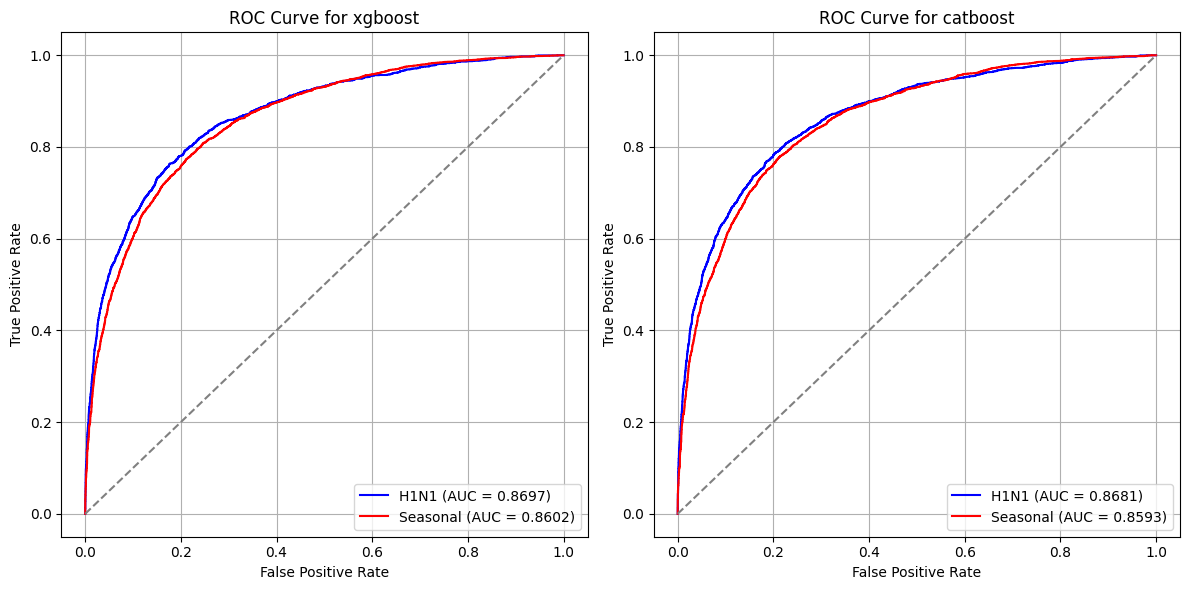

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

models_xgboost = process_model('xgboost', axes[0])
models_catboost = process_model('catboost', axes[1])

plt.tight_layout()
plt.show()

## Feature Selection

In [14]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


def select_features(model, data, target: Literal['h1n1_vaccine', 'seasonal_vaccine'], ct = None):
    sfs = SFS(
        estimator=model, 
        k_features='best', 
        forward=True, 
        floating=False, 
        verbose=2,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1
    )

    if ct is not None:
        data = ct.fit_transform(data)
    
    sfs = sfs.fit(data, np.array(y_train[target]).ravel())
    
    sfdf = pd.DataFrame(sfs.get_metric_dict()).T
    
    print(sfdf.loc[18, 'feature_idx'])
    plot_sfs(sfs.get_metric_dict(), kind='std_err', figsize=(15,6))

    plt.title('ROC AUC with features number')
    plt.grid()
    plt.show()
    
    return sfdf

### CatBoost H1N1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


[Parallel(n_jobs=-1)]: Done  12 out of  35 | elapsed:    8.6s remaining:   16.6s
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed:   10.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   11.2s finished

[2024-10-24 04:37:13] Features: 1/35 -- score: 0.7004752319456309[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  34 | elapsed:    7.0s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  29 out of  34 | elapsed:    8.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    9.2s finished

[2024-10-24 04:37:22] Features: 2/35 -- score: 0.7893181040252959[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  33 | elapsed:    4.3s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done  23 out of  33 | elapsed:    8.2s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    9.1s finished

[2024-10-24 04

(0, 1, 3, 6, 8, 12, 13, 14, 15, 21, 22, 25, 26, 27, 28, 29, 31, 32)


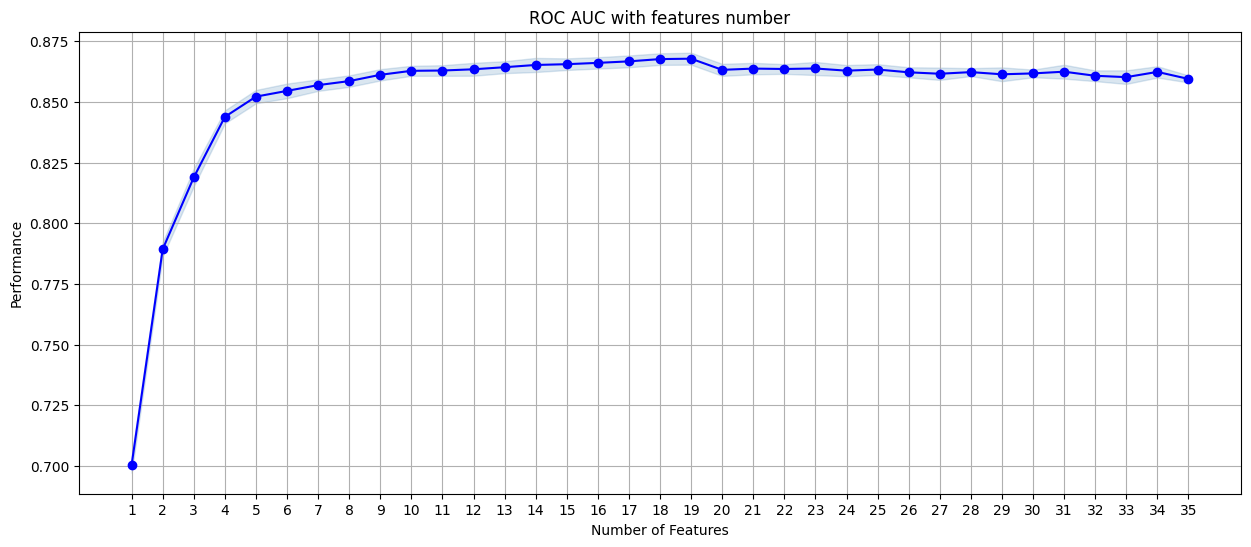

(0, 1, 3, 6, 8, 9, 12, 13, 14, 15, 21, 22, 25, 26, 27, 28, 29, 31, 32)


['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_avoidance',
 'behavioral_large_gatherings',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'household_adults',
 'household_children',
 'marital_status',
 'rent_or_own',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'age_group',
 'education']

In [15]:
params_catboost_h1n1 = {
    'n_estimators': 100,
    'verbose': False,
}

ct = ColumnTransformer(
    [('ordinal', OrdinalEncoder(), cat_cols + ord_cols)],
    remainder='passthrough'
)

sfs_model_catboost_h1n1 = CatBoostClassifier(**params_catboost_h1n1)
sfdf_catboost_h1n1 = select_features(sfs_model_catboost_h1n1, X_train_catboost, 'h1n1_vaccine', ct=ct)
print(sfdf_catboost_h1n1.loc[19, 'feature_idx'])
selected_columns_catboost_h1n1 = [X_train_catboost.columns[i] for i in  list(sfdf_catboost_h1n1.loc[19, 'feature_idx'])]
selected_columns_catboost_h1n1


### CatBoost Seasonal

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  35 | elapsed:    4.2s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed:    7.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    8.0s finished

[2024-10-24 04:42:31] Features: 1/35 -- score: 0.7132087052418979[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  34 | elapsed:    5.5s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  29 out of  34 | elapsed:    9.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    9.5s finished

[2024-10-24 04:42:41] Features: 2/35 -- score: 0.7750429687268088[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  33 | elapsed:    4.6s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  23 out of  33 | elapsed:    8.6s remaining:    3.7s
[Parallel

(0, 2, 6, 8, 9, 13, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 32, 34)


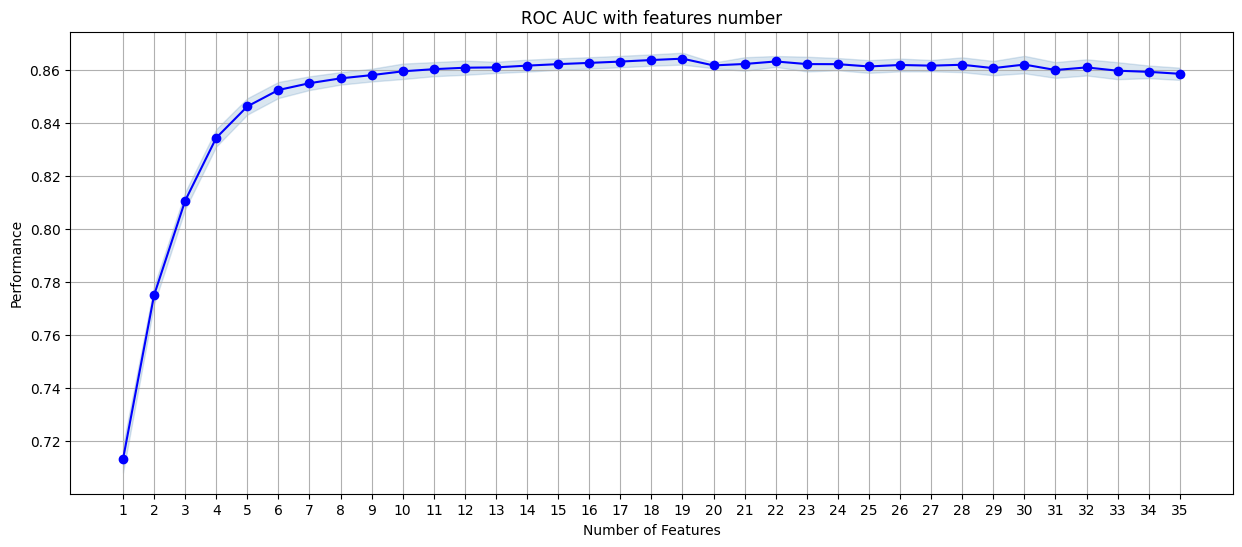

In [16]:
sfdf_catboost_seasonal = select_features(sfs_model_catboost_h1n1, X_train_catboost, 'seasonal_vaccine', ct=ct)

In [45]:
print(sfdf_catboost_seasonal.loc[19, 'feature_idx'])
selected_columns_catboost_seasonal = [X_train_catboost.columns[i] for i in  list(sfdf_catboost_seasonal.loc[19, 'feature_idx'])]
selected_columns_catboost_seasonal

(0, 2, 6, 8, 9, 13, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 34)


['h1n1_concern',
 'behavioral_antiviral_meds',
 'behavioral_large_gatherings',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'health_worker',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children',
 'race',
 'marital_status',
 'rent_or_own',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'employment_occupation',
 'age_group',
 'education',
 'employment_status']

### XGBoost H1N1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


[Parallel(n_jobs=-1)]: Done  53 out of  98 | elapsed:    4.3s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    4.7s finished

[2024-10-24 04:52:42] Features: 1/98 -- score: 0.7004752319456309[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 out of  97 | elapsed:    1.0s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:    1.3s finished

[2024-10-24 04:52:43] Features: 2/98 -- score: 0.7893191638151043[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  96 | elapsed:    1.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.9s finished

[2024-10-24 04:52:45] Features: 3/98 -- score: 0.8187334463617381[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  95 | elapsed:    1.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  95 ou

(2, 9, 10, 13, 14, 15, 16, 48, 51, 53, 58, 60, 62, 64, 73, 83, 84, 93)


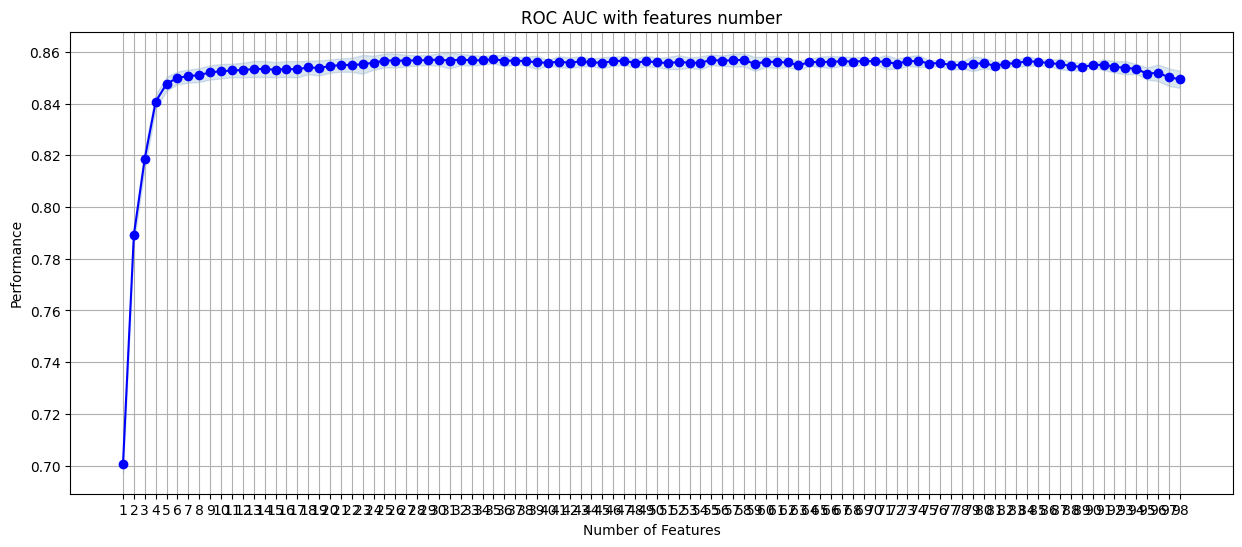

In [20]:
params = {
    'n_estimators': 100,
}

sfs_model_xgboost_h1n1 =  xgb.XGBClassifier(**params)
sfdf_xgboost_h1n1 = select_features(sfs_model_xgboost_h1n1, X_train_xgboost, 'h1n1_vaccine')

In [29]:
print(sfdf_xgboost_h1n1.loc[23, 'feature_idx'])
selected_columns_xgboost_h1n1 = [X_train_xgboost.columns[i] for i in  list(sfdf_xgboost_h1n1.loc[23, 'feature_idx'])]
selected_columns_xgboost_h1n1

(1, 2, 9, 10, 11, 13, 14, 15, 16, 19, 31, 48, 51, 53, 58, 60, 62, 64, 65, 73, 83, 84, 93)


['h1n1_knowledge',
 'behavioral_antiviral_meds',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_seas_risk',
 'marital_status_missing',
 'employment_industry_arjwrbjb',
 'employment_industry_dotnnunm',
 'employment_industry_haxffmxo',
 'employment_industry_msuufmds',
 'employment_industry_phxvnwax',
 'employment_industry_qnlwzans',
 'employment_industry_saaquncn',
 'employment_industry_vjjrobsf',
 'employment_occupation_dcjcmpih',
 'employment_occupation_pvmttkik',
 'employment_occupation_qxajmpny',
 'employment_occupation_xzmlyyjv']

### XGBoost Seasonal

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  98 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    1.2s finished

[2024-10-24 04:57:18] Features: 1/98 -- score: 0.7132087052418979[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 out of  97 | elapsed:    1.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:    1.6s finished

[2024-10-24 04:57:20] Features: 2/98 -- score: 0.7750691241463841[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  96 | elapsed:    1.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    2.2s finished

[2024-10-24 04:57:22] Features: 3/98 -- score: 0.8102245159444437[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of

(10, 11, 13, 14, 18, 19, 20, 33, 53, 58, 59, 60, 68, 73, 79, 87, 88, 94)


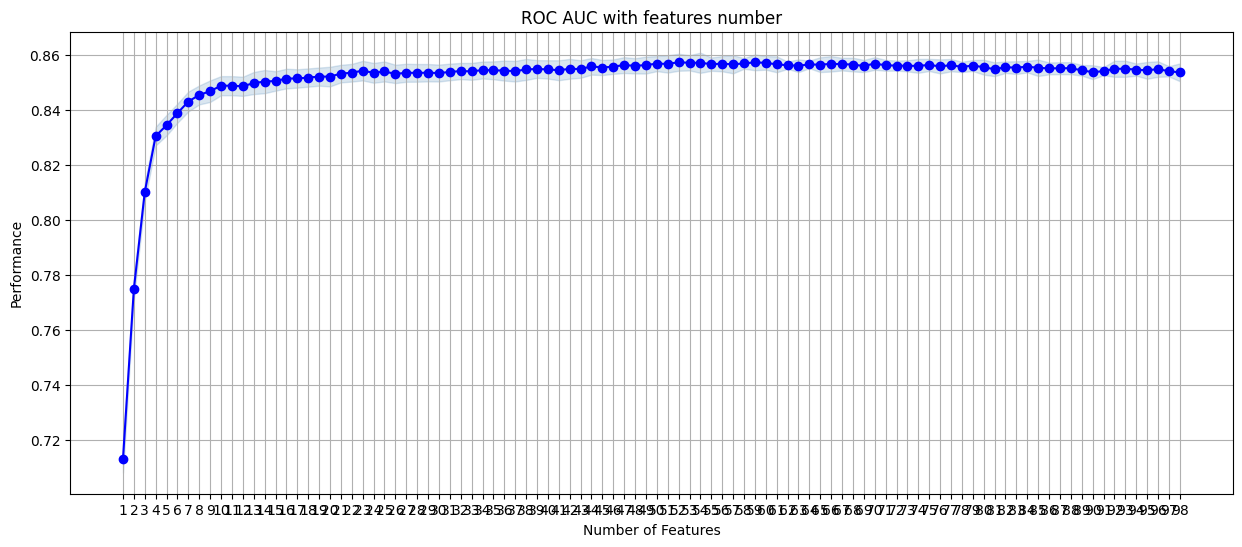

In [22]:
sfdf_xgboost_seasonal = select_features(sfs_model_xgboost_h1n1, X_train_xgboost, 'seasonal_vaccine')

In [28]:
print(sfdf_xgboost_seasonal.loc[51, 'feature_idx'])
selected_columns_xgboost_seasonal = [X_train_xgboost.columns[i] for i in  list(sfdf_xgboost_seasonal.loc[51, 'feature_idx'])]
selected_columns_xgboost_seasonal

(1, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 32, 33, 34, 37, 42, 47, 49, 51, 53, 54, 55, 56, 58, 59, 60, 62, 63, 64, 66, 68, 72, 73, 74, 75, 79, 81, 82, 83, 85, 87, 88, 89, 90, 94, 96)


['h1n1_knowledge',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'race_Black',
 'race_Hispanic',
 'race_Other or Multiple',
 'rent_or_own_Own',
 'rent_or_own_Rent',
 'rent_or_own_missing',
 'hhs_geo_region_dqpwygqj',
 'hhs_geo_region_mlyzmhmf',
 'census_msa_Non-MSA',
 'employment_industry_atmlpfrs',
 'employment_industry_dotnnunm',
 'employment_industry_haxffmxo',
 'employment_industry_ldnlellj',
 'employment_industry_mcubkhph',
 'employment_industry_mfikgejo',
 'employment_industry_msuufmds',
 'employment_industry_nduyfdeo',
 'employment_industry_phxvnwax',
 'employment_industry_qnlwzans',
 'employment_industry_rucpziij',
 'employment_industry_saaquncn',
 'employment_industry_wlfvacwt',
 'employment_industry_xicduogh',
 'empl

In [46]:
train_catboost_h1n1_selected = X_train_catboost[selected_columns_catboost_h1n1]
test_catboost_h1n1_selected = X_test_catboost[selected_columns_catboost_h1n1]
train_catboost_seasonal_selected = X_train_catboost[selected_columns_catboost_seasonal]
test_catboost_seasonal_selected = X_test_catboost[selected_columns_catboost_seasonal]

train_xgboost_h1n1_selected = X_train_xgboost[selected_columns_xgboost_h1n1]
test_xgboost_h1n1_selected = X_test_xgboost[selected_columns_xgboost_h1n1]
train_xgboost_seasonal_selected = X_train_xgboost[selected_columns_xgboost_seasonal]
test_xgboost_seasonal_selected = X_test_xgboost[selected_columns_xgboost_seasonal]

Mean ROC AUC (xgboost) = 0.8618
Mean ROC AUC (catboost) = 0.7977


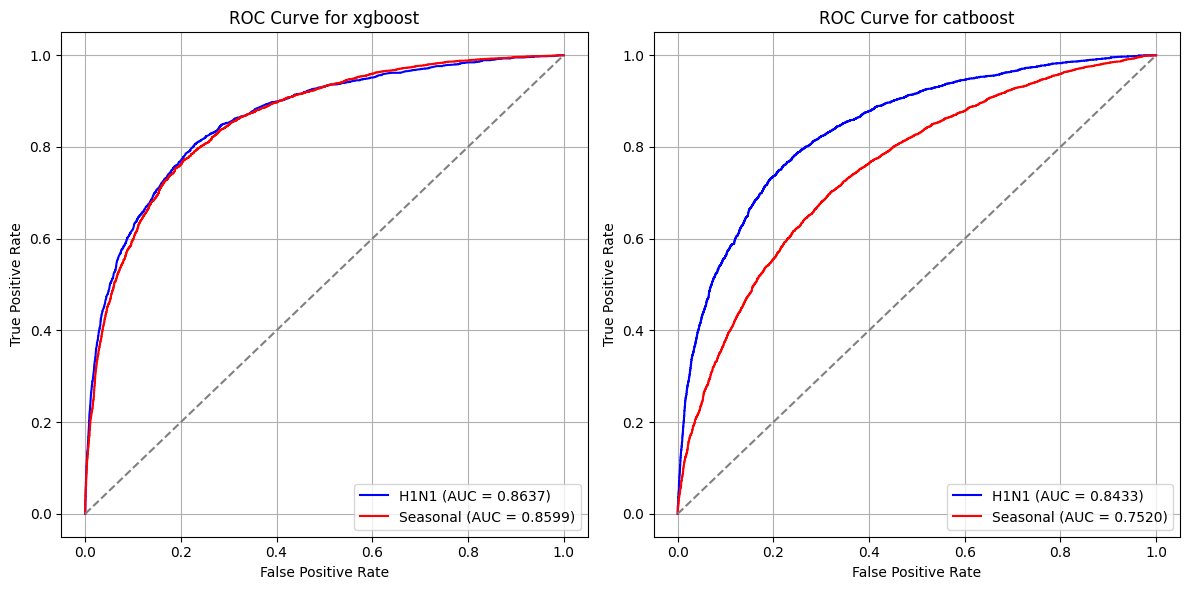

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

models_xgboost = process_model(
    'xgboost',
    axes[0],
    X_train_changed_h1n1=train_xgboost_h1n1_selected,
    X_test_changed_h1n1=test_xgboost_h1n1_selected,
    X_train_changed_seasonal=train_xgboost_seasonal_selected,
    X_test_changed_seasonal=test_xgboost_seasonal_selected
)

cat_cols_selected_h1n1 = [col for col in cat_cols if col in selected_columns_catboost_h1n1]
cat_cols_selected_seasonal = [col for col in cat_cols if col in selected_columns_catboost_seasonal]

models_catboost = process_model(
    'catboost',
    axes[1],
    X_train_changed_h1n1=train_catboost_h1n1_selected,
    X_test_changed_h1n1=test_catboost_h1n1_selected,
    X_train_changed_seasonal=train_catboost_seasonal_selected,
    X_test_changed_seasonal=test_catboost_seasonal_selected,
    cat_cols_selected_h1n1=cat_cols_selected_h1n1,
    cat_cols_selected_seasonal=cat_cols_selected_seasonal
)

plt.tight_layout()
plt.show()

In [71]:
import optuna
from catboost import Pool, cv


def get_optimal_params_catboost(target: Literal['h1n1_vaccine', 'seasonal_vaccine']) -> Dict:
    cat_features_indices = list(range(23, 23 + len(cat_cols)))
    train_dataset = Pool(
        data=X_train_catboost,
        label=y_train[target],
        cat_features=cat_features_indices
    )
    
    def objective(trial):
        param = {
            'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
            'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
            'random_strength':trial.suggest_int("random_strength", 1,10),
            'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
            'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
            'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
            'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
            'od_type' : "Iter",
            'od_wait' : 100,
            "depth": trial.suggest_int("max_depth", 2,10),
            "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
            'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
            'custom_metric' : ['AUC'],
            "loss_function": "Logloss",
            'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

        scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,
            plot=False, verbose=False
        )

        return scores['test-AUC-mean'].max()
    
    sampler = optuna.samplers.TPESampler(seed=68)  # Make the sampler behave in a deterministic way.
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=100, n_jobs=-1)
    
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}={},".format(key, value))
    
    return trial.params

In [66]:
from sklearn.metrics import roc_auc_score


def get_optimal_params_xgboost(target: Literal['h1n1_vaccine', 'seasonal_vaccine']) -> Dict:
    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'tree_method': 'hist',
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
            'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
            'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1),
        }

        dtrain = xgb.DMatrix(X_train_xgboost, label=y_train[target])
        dvalid = xgb.DMatrix(X_test_xgboost, label=y_test[target])
        model = xgb.train(params, dtrain, num_boost_round=1000, 
                        evals=[(dvalid, 'validation')], early_stopping_rounds=20, verbose_eval=False)
        
        y_pred = model.predict(dvalid)
        return roc_auc_score(y_test[target], y_pred)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, n_jobs=-1)
    
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}={},".format(key, value))
    
    return trial.params

In [67]:
optimal_params_xgboost_h1n1 = get_optimal_params_xgboost('h1n1_vaccine')

[I 2024-10-24 05:46:54,175] A new study created in memory with name: no-name-3a141c8d-e5e2-4cd3-8660-6e14d0651365
/tmp/ipykernel_3941332/4069439842.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_3941332/4069439842.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
/tmp/ipykernel_3941332/4069439842.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('cols

Number of finished trials: 100
Best trial:
  Value: 0.8698236703229408
  Params: 
    max_depth=6,
    learning_rate=0.022836748443996822,
    subsample=0.8653553353246172,
    colsample_bytree=0.587759794658415,
    min_child_weight=4.694801169092555e-05,


In [68]:
optimal_params_xgboost_seasonal = get_optimal_params_xgboost('seasonal_vaccine')

[I 2024-10-24 05:48:17,541] A new study created in memory with name: no-name-771bcdfe-7da7-4849-bbd6-93bc57c1495b
/tmp/ipykernel_3941332/4069439842.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_3941332/4069439842.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
/tmp/ipykernel_3941332/4069439842.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('cols

Number of finished trials: 100
Best trial:
  Value: 0.8602868529204201
  Params: 
    max_depth=6,
    learning_rate=0.00800974974569802,
    subsample=0.4385020915860596,
    colsample_bytree=0.4499608807970106,
    min_child_weight=0.0001293532400837436,


In [72]:
optimal_params_catboost_h1n1 = get_optimal_params_catboost('h1n1_vaccine')

[I 2024-10-24 05:55:03,448] A new study created in memory with name: no-name-2fdf9038-b6cd-4574-8dbf-23576159bc44
/tmp/ipykernel_3941332/1713715200.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),


Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on

[I 2024-10-24 05:55:38,441] Trial 4 finished with value: 0.8485143189334547 and parameters: {'iterations': 500, 'learning_rate': 0.2680497729628723, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 9.365006402296821e-07, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.8485143189334547.



bestTest = 0.4764564435
bestIteration = 18


bestTest = 0.4395739166
bestIteration = 20

Training on fold [2/5]

bestTest = 0.5053705741
bestIteration = 16

Training on fold [0/5]
Training on fold [2/5]

bestTest = 0.5180684773
bestIteration = 8

Training on fold [2/5]

bestTest = 0.4421004961
bestIteration = 31

Training on fold [2/5]

bestTest = 0.4222622798
bestIteration = 91

Training on fold [2/5]

bestTest = 0.4514011116
bestIteration = 22

Training on fold [2/5]

bestTest = 0.434510524
bestIteration = 39

Training on fold [2/5]

bestTest = 0.4743593771
bestIteration = 40

Training on fold [3/5]

bestTest = 0.4637901411
bestIteration = 44

Training on fold [3/5]

bestTest = 0.4728858279
bestIteration = 48

Training on fold [4/5]

bestTest = 0.4656910689
bestIteration = 16

Training on fold [2/5]

bestTest = 0.4771633443
bestIteration = 61

Training on fold [1/5]

bestTest = 0.5300923815
bestIteration = 7

Training on fold [2/5]

bestTest = 0.4535451288
bestIteration = 116

Train

[I 2024-10-24 05:55:53,947] Trial 16 finished with value: 0.8519953127050993 and parameters: {'iterations': 1200, 'learning_rate': 0.2658839414169343, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 0.000789960157147103, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 16 with value: 0.8519953127050993.



bestTest = 0.472625565
bestIteration = 49

Training on fold [0/5]

bestTest = 0.4541888714
bestIteration = 81

Training on fold [2/5]

bestTest = 0.4634387185
bestIteration = 52

Training on fold [4/5]

bestTest = 0.4476147965
bestIteration = 29

Training on fold [3/5]

bestTest = 0.4982755284
bestIteration = 26

Training on fold [3/5]

bestTest = 0.4987209082
bestIteration = 33

Training on fold [1/5]

bestTest = 0.4679849222
bestIteration = 91

Training on fold [3/5]

bestTest = 0.4784695705
bestIteration = 38

Training on fold [4/5]

bestTest = 0.445444766
bestIteration = 28

Training on fold [3/5]

bestTest = 0.4259578823
bestIteration = 76

Training on fold [4/5]

bestTest = 0.4848933888
bestIteration = 17

Training on fold [3/5]

bestTest = 0.4958404776
bestIteration = 24

Training on fold [3/5]

bestTest = 0.4301316697
bestIteration = 51

Training on fold [3/5]

bestTest = 0.4913037721
bestIteration = 13

Training on fold [4/5]

bestTest = 0.4536782051
bestIteration = 52

Train

[I 2024-10-24 05:56:09,064] Trial 2 finished with value: 0.8444952835525189 and parameters: {'iterations': 1500, 'learning_rate': 0.26058774784674577, 'random_strength': 5, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 1.1876454820905452e-06, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 16 with value: 0.8519953127050993.



bestTest = 0.5053060092
bestIteration = 4

Training on fold [0/5]

bestTest = 0.4686868682
bestIteration = 46

Training on fold [3/5]

bestTest = 0.4457381496
bestIteration = 49

Training on fold [3/5]

bestTest = 0.4674552025
bestIteration = 58

Training on fold [3/5]


[I 2024-10-24 05:56:11,467] Trial 27 finished with value: 0.859334052973033 and parameters: {'iterations': 1200, 'learning_rate': 0.29232698435549875, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 3, 'l2_leaf_reg': 0.19741150113314732, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 27 with value: 0.859334052973033.
[I 2024-10-24 05:56:11,652] Trial 24 finished with value: 0.8613661859373144 and parameters: {'iterations': 1000, 'learning_rate': 0.2676396655362042, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 3, 'l2_leaf_reg': 0.01756618575152509, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 24 with value: 0.8613661859373144.



bestTest = 0.4557933893
bestIteration = 70


bestTest = 0.4184031658
bestIteration = 97

Training on fold [2/5]
Training on fold [0/5]

bestTest = 0.4218064622
bestIteration = 60


bestTest = 0.4833893748
bestIteration = 48

Training on fold [1/5]
Training on fold [0/5]

bestTest = 0.4495501605
bestIteration = 144

Training on fold [2/5]

bestTest = 0.5227048135
bestIteration = 39

Training on fold [1/5]

bestTest = 0.4703836729
bestIteration = 20

Training on fold [3/5]

bestTest = 0.459631179
bestIteration = 107

Training on fold [4/5]


[I 2024-10-24 05:56:14,228] Trial 5 finished with value: 0.849210330301597 and parameters: {'iterations': 1000, 'learning_rate': 0.2970384408415001, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 4, 'l2_leaf_reg': 7.639266328872399e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 24 with value: 0.8613661859373144.



bestTest = 0.4635432067
bestIteration = 42

Training on fold [0/5]

bestTest = 0.4442467167
bestIteration = 16


bestTest = 0.5295931293
bestIteration = 11

Training on fold [4/5]
Training on fold [4/5]

bestTest = 0.4790110337
bestIteration = 24

Training on fold [4/5]

bestTest = 0.4729984848
bestIteration = 31

Training on fold [2/5]

bestTest = 0.4673857832
bestIteration = 15

Training on fold [4/5]

bestTest = 0.4295203245
bestIteration = 43

Training on fold [4/5]

bestTest = 0.5144062203
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4647653538
bestIteration = 70

Training on fold [2/5]

bestTest = 0.4712847948
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4490454847
bestIteration = 54

Training on fold [4/5]


[I 2024-10-24 05:56:23,498] Trial 41 finished with value: 0.8605043305773254 and parameters: {'iterations': 100, 'learning_rate': 0.2624582081735853, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 2, 'l2_leaf_reg': 7.859875538016088e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 24 with value: 0.8613661859373144.



bestTest = 0.423720325
bestIteration = 90

Training on fold [0/5]

bestTest = 0.4217562253
bestIteration = 136

Training on fold [2/5]

bestTest = 0.4606631882
bestIteration = 261

Training on fold [2/5]

bestTest = 0.5093386023
bestIteration = 11

Training on fold [4/5]

bestTest = 0.4945228467
bestIteration = 185

Training on fold [1/5]

bestTest = 0.4543046094
bestIteration = 72

Training on fold [2/5]

bestTest = 0.4689321036
bestIteration = 39

Training on fold [4/5]

bestTest = 0.4996069259
bestIteration = 29

Training on fold [4/5]


[I 2024-10-24 05:56:28,115] Trial 23 finished with value: 0.8548285731899845 and parameters: {'iterations': 1500, 'learning_rate': 0.2049206026438633, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.00028308787770520166, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 24 with value: 0.8613661859373144.



bestTest = 0.4629864712
bestIteration = 70

Training on fold [0/5]

bestTest = 0.4429072362
bestIteration = 80

Training on fold [1/5]

bestTest = 0.4674699358
bestIteration = 50

Training on fold [3/5]

bestTest = 0.4411571414
bestIteration = 35

Training on fold [4/5]


[I 2024-10-24 05:56:30,736] Trial 15 finished with value: 0.8508651548600475 and parameters: {'iterations': 1500, 'learning_rate': 0.21363060354177704, 'random_strength': 2, 'bagging_temperature': 0, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 0.07197589682693149, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 24 with value: 0.8613661859373144.



bestTest = 0.4722397184
bestIteration = 49

Training on fold [2/5]

bestTest = 0.4361828164
bestIteration = 19

Training on fold [0/5]

bestTest = 0.513116628
bestIteration = 14

Training on fold [4/5]

bestTest = 0.4902250612
bestIteration = 21

Training on fold [3/5]

bestTest = 0.4644996203
bestIteration = 97

Training on fold [3/5]


[I 2024-10-24 05:56:32,542] Trial 0 finished with value: 0.8629665602520473 and parameters: {'iterations': 200, 'learning_rate': 0.2241904623531684, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 12.772272555517809, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4553755013
bestIteration = 122

Training on fold [0/5]

bestTest = 0.4208926858
bestIteration = 393

Training on fold [2/5]


[I 2024-10-24 05:56:35,036] Trial 37 finished with value: 0.8285958792728497 and parameters: {'iterations': 1200, 'learning_rate': 0.26478555846199037, 'random_strength': 4, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 8.23534298961012e-08, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.5112666511
bestIteration = 10

Training on fold [0/5]

bestTest = 0.419323034
bestIteration = 151

Training on fold [2/5]


[I 2024-10-24 05:56:35,416] Trial 21 finished with value: 0.8344959874388241 and parameters: {'iterations': 1200, 'learning_rate': 0.18882819250175967, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 7.983329475874708e-07, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4640147674
bestIteration = 18

Training on fold [0/5]

bestTest = 0.4672245772
bestIteration = 83

Training on fold [3/5]


[I 2024-10-24 05:56:37,202] Trial 20 finished with value: 0.845274667428462 and parameters: {'iterations': 200, 'learning_rate': 0.12702632279378415, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 0.00019571370054434622, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4789326854
bestIteration = 30

Training on fold [0/5]

bestTest = 0.4771617814
bestIteration = 161

Training on fold [1/5]

bestTest = 0.4564407369
bestIteration = 96

Training on fold [4/5]

bestTest = 0.4463395108
bestIteration = 87

Training on fold [1/5]

bestTest = 0.5403383561
bestIteration = 16

Training on fold [3/5]

bestTest = 0.4757857602
bestIteration = 22

Training on fold [4/5]

bestTest = 0.4789604349
bestIteration = 92

Training on fold [1/5]


[I 2024-10-24 05:56:41,869] Trial 1 finished with value: 0.85849612420293 and parameters: {'iterations': 100, 'learning_rate': 0.12023549291542554, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 2, 'l2_leaf_reg': 0.2950562586401372, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8629665602520473.
[I 2024-10-24 05:56:41,927] Trial 29 finished with value: 0.8596845990019653 and parameters: {'iterations': 300, 'learning_rate': 0.2786096894149345, 'random_strength': 2, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 2.8045639631966045e-05, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4653412204
bestIteration = 97


bestTest = 0.4184915742
bestIteration = 59

Training on fold [0/5]
Training on fold [0/5]


[I 2024-10-24 05:56:42,547] Trial 26 finished with value: 0.859870704763303 and parameters: {'iterations': 500, 'learning_rate': 0.13306440756300358, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 9.420954901373326e-08, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4638522336
bestIteration = 37

Training on fold [0/5]


[I 2024-10-24 05:56:43,366] Trial 38 finished with value: 0.8477957585613648 and parameters: {'iterations': 300, 'learning_rate': 0.25438729131231674, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 3.5408926718691177e-06, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4401751084
bestIteration = 38

Training on fold [0/5]


[I 2024-10-24 05:56:44,607] Trial 3 finished with value: 0.8477573440410652 and parameters: {'iterations': 100, 'learning_rate': 0.23853864967481658, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 10, 'l2_leaf_reg': 0.001626003218491417, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4209315865
bestIteration = 89

Training on fold [2/5]

bestTest = 0.4414688109
bestIteration = 21

Training on fold [0/5]

bestTest = 0.4272281463
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4693337099
bestIteration = 73

Training on fold [3/5]

bestTest = 0.4754570047
bestIteration = 21

Training on fold [4/5]


[I 2024-10-24 05:56:49,393] Trial 47 finished with value: 0.8391606213015551 and parameters: {'iterations': 500, 'learning_rate': 0.20661663894089127, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 0.0001331642555330036, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4972926922
bestIteration = 22

Training on fold [0/5]


[I 2024-10-24 05:56:50,465] Trial 46 finished with value: 0.8301905428500909 and parameters: {'iterations': 100, 'learning_rate': 0.2555711425084048, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 0.00016100469351785753, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4769401685
bestIteration = 112

Training on fold [1/5]

bestTest = 0.5121869875
bestIteration = 8

Training on fold [0/5]

bestTest = 0.4665687155
bestIteration = 55

Training on fold [3/5]


[I 2024-10-24 05:56:53,347] Trial 25 finished with value: 0.8319468938112526 and parameters: {'iterations': 200, 'learning_rate': 0.24894406534029362, 'random_strength': 8, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 9, 'l2_leaf_reg': 0.04054586499907761, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4994274227
bestIteration = 20

Training on fold [0/5]

bestTest = 0.5083142608
bestIteration = 94

Training on fold [1/5]

bestTest = 0.4645393337
bestIteration = 43

Training on fold [4/5]

bestTest = 0.4436606534
bestIteration = 95

Training on fold [1/5]

bestTest = 0.4185265523
bestIteration = 84

Training on fold [2/5]

bestTest = 0.4380989914
bestIteration = 322

Training on fold [1/5]

bestTest = 0.4699989457
bestIteration = 221

Training on fold [3/5]

bestTest = 0.459403599
bestIteration = 88

Training on fold [4/5]

bestTest = 0.4281185422
bestIteration = 93

Training on fold [3/5]


[I 2024-10-24 05:57:02,292] Trial 18 finished with value: 0.8246413368805753 and parameters: {'iterations': 1500, 'learning_rate': 0.13627188039957483, 'random_strength': 10, 'bagging_temperature': 1, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 1.1545850789581286e-07, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4781270674
bestIteration = 17



[I 2024-10-24 05:57:02,568] Trial 9 finished with value: 0.8629011917618901 and parameters: {'iterations': 1200, 'learning_rate': 0.15508091063420648, 'random_strength': 2, 'bagging_temperature': 6, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 2.691933635736451, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8629665602520473.


Training on fold [0/5]

bestTest = 0.4541165329
bestIteration = 84


bestTest = 0.4528170941
bestIteration = 190

Training on fold [0/5]
Training on fold [1/5]

bestTest = 0.462712709
bestIteration = 92

Training on fold [4/5]

bestTest = 0.457822916
bestIteration = 109

Training on fold [2/5]


[I 2024-10-24 05:57:05,038] Trial 48 finished with value: 0.8528609611128338 and parameters: {'iterations': 1500, 'learning_rate': 0.1436316855863077, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 9, 'l2_leaf_reg': 1.3494718680773809e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8629665602520473.




bestTest = 0.4681506042
bestIteration = 25

bestTest = 0.463544062
bestIteration = 62

Training on fold [3/5]

bestTest = 0.4520225486
bestIteration = 199

Training on fold [1/5]
Training on fold [0/5]

bestTest = 0.4355319009
bestIteration = 58

Training on fold [3/5]

bestTest = 0.4289316912
bestIteration = 171

Training on fold [3/5]

bestTest = 0.4712272957
bestIteration = 43

Training on fold [4/5]

bestTest = 0.4553308561
bestIteration = 98

Training on fold [2/5]

bestTest = 0.4691309639
bestIteration = 96

Training on fold [3/5]

bestTest = 0.5236146386
bestIteration = 13


bestTest = 0.4604911939
bestIteration = 56

Training on fold [4/5]
Training on fold [4/5]

bestTest = 0.431562493
bestIteration = 108

Training on fold [2/5]

bestTest = 0.471420955
bestIteration = 59

Training on fold [3/5]

bestTest = 0.4244272918
bestIteration = 96

Training on fold [4/5]


[I 2024-10-24 05:57:19,481] Trial 36 finished with value: 0.8615858120177364 and parameters: {'iterations': 1000, 'learning_rate': 0.28849088515390225, 'random_strength': 8, 'bagging_temperature': 0, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 1.2372807388211173, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4578565819
bestIteration = 42

Training on fold [0/5]

bestTest = 0.4561938724
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4417724794
bestIteration = 231

Training on fold [1/5]

bestTest = 0.4307866901
bestIteration = 393

Training on fold [3/5]

bestTest = 0.4315802521
bestIteration = 70

Training on fold [4/5]

bestTest = 0.4199481556
bestIteration = 144

Training on fold [2/5]

bestTest = 0.4854094748
bestIteration = 297

Training on fold [1/5]

bestTest = 0.4211928881
bestIteration = 140

Training on fold [4/5]


[I 2024-10-24 05:57:25,565] Trial 49 finished with value: 0.858198499898417 and parameters: {'iterations': 500, 'learning_rate': 0.29619076657818394, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 4, 'l2_leaf_reg': 1.4700162630612735e-08, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8629665602520473.



bestTest = 0.4605943808
bestIteration = 38

Training on fold [0/5]

bestTest = 0.4630332905
bestIteration = 108

Training on fold [4/5]


[I 2024-10-24 05:57:29,592] Trial 6 finished with value: 0.86342595598792 and parameters: {'iterations': 100, 'learning_rate': 0.14637789882876173, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 4, 'l2_leaf_reg': 12.756386387607467, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86342595598792.



bestTest = 0.4421065307
bestIteration = 348

Training on fold [1/5]

bestTest = 0.4534689251
bestIteration = 98

Training on fold [0/5]

bestTest = 0.4607104737
bestIteration = 252

Training on fold [4/5]

bestTest = 0.4302634145
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4577697507
bestIteration = 199

Training on fold [1/5]

bestTest = 0.5003595717
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4147963591
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4286661528
bestIteration = 186

Training on fold [3/5]

bestTest = 0.491251142
bestIteration = 50

Training on fold [2/5]

bestTest = 0.4664679817
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4396244939
bestIteration = 453

Training on fold [1/5]


[I 2024-10-24 05:57:38,522] Trial 54 finished with value: 0.8607795650839829 and parameters: {'iterations': 200, 'learning_rate': 0.2840173130769693, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 9.982064051970662e-06, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.86342595598792.



bestTest = 0.4205115998
bestIteration = 90

Training on fold [0/5]

bestTest = 0.4429976284
bestIteration = 322

Training on fold [1/5]

bestTest = 0.4406520257
bestIteration = 361

Training on fold [1/5]

bestTest = 0.477751372
bestIteration = 98

Training on fold [2/5]


[I 2024-10-24 05:57:40,905] Trial 33 finished with value: 0.8622284933053134 and parameters: {'iterations': 1000, 'learning_rate': 0.2837373508919815, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 34.014110672120495, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86342595598792.



bestTest = 0.4536814235
bestIteration = 47

Training on fold [0/5]

bestTest = 0.4431250842
bestIteration = 251

Training on fold [1/5]

bestTest = 0.4650047757
bestIteration = 81

Training on fold [3/5]


[I 2024-10-24 05:57:43,330] Trial 52 finished with value: 0.8625910600542717 and parameters: {'iterations': 1200, 'learning_rate': 0.1620134148849819, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 4, 'l2_leaf_reg': 0.009010650909531404, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.86342595598792.



bestTest = 0.4205083281
bestIteration = 96

Training on fold [0/5]

bestTest = 0.4582692397
bestIteration = 60

Training on fold [4/5]


[I 2024-10-24 05:57:44,519] Trial 14 finished with value: 0.8631583378514331 and parameters: {'iterations': 1000, 'learning_rate': 0.20566915988793255, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.037208462676519574, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86342595598792.



bestTest = 0.4514371191
bestIteration = 137


bestTest = 0.4612926565
bestIteration = 199

Training on fold [1/5]


[I 2024-10-24 05:57:44,924] Trial 56 finished with value: 0.8614587134554803 and parameters: {'iterations': 1500, 'learning_rate': 0.20519790833018822, 'random_strength': 4, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 2, 'l2_leaf_reg': 3.24433914765201e-05, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86342595598792.



bestTest = 0.4571659857
bestIteration = 126

Training on fold [0/5]

bestTest = 0.4406380981
bestIteration = 382

Training on fold [1/5]
Training on fold [0/5]

bestTest = 0.4361122931
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4417035423
bestIteration = 443

Training on fold [1/5]

bestTest = 0.4670578406
bestIteration = 65

Training on fold [4/5]

bestTest = 0.436820856
bestIteration = 296

Training on fold [1/5]

bestTest = 0.4245983953
bestIteration = 158

Training on fold [4/5]

bestTest = 0.4836242274
bestIteration = 201

Training on fold [1/5]

bestTest = 0.4401856467
bestIteration = 428

Training on fold [1/5]


[I 2024-10-24 05:57:55,086] Trial 8 finished with value: 0.8652630304224008 and parameters: {'iterations': 100, 'learning_rate': 0.13886001476584953, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 3, 'l2_leaf_reg': 0.0007206018517211725, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4144599105
bestIteration = 99

Training on fold [0/5]


[I 2024-10-24 05:57:56,191] Trial 12 finished with value: 0.8195984424557325 and parameters: {'iterations': 1200, 'learning_rate': 0.1339936994689055, 'random_strength': 7, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 10, 'l2_leaf_reg': 1.4697934529895385e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.5321513857
bestIteration = 16

Training on fold [0/5]

bestTest = 0.4758678675
bestIteration = 202

Training on fold [2/5]

bestTest = 0.469879794
bestIteration = 299

Training on fold [1/5]

bestTest = 0.439831083
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4276544914
bestIteration = 383

Training on fold [4/5]

bestTest = 0.4883188676
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4378331311
bestIteration = 379

Training on fold [1/5]


[I 2024-10-24 05:58:10,111] Trial 32 finished with value: 0.8615057097914078 and parameters: {'iterations': 1000, 'learning_rate': 0.06159199360671247, 'random_strength': 10, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 3, 'l2_leaf_reg': 2.66754285009512e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.456559301
bestIteration = 264

Training on fold [0/5]

bestTest = 0.4418300537
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4814661341
bestIteration = 199

Training on fold [1/5]

bestTest = 0.441574687
bestIteration = 662

Training on fold [1/5]

bestTest = 0.4292081985
bestIteration = 96

Training on fold [3/5]

bestTest = 0.4790683007
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4727991849
bestIteration = 182

Training on fold [1/5]

bestTest = 0.4225152166
bestIteration = 177

Training on fold [2/5]

bestTest = 0.4901735616
bestIteration = 59

Training on fold [3/5]

bestTest = 0.4555887989
bestIteration = 100

Training on fold [4/5]

bestTest = 0.4397148362
bestIteration = 89

Training on fold [3/5]

bestTest = 0.4357492338
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4206936965
bestIteration = 373

Training on fold [2/5]


[I 2024-10-24 05:58:25,053] Trial 31 finished with value: 0.8635523768901928 and parameters: {'iterations': 500, 'learning_rate': 0.20709206381170786, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 96.51772032968897, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4524498824
bestIteration = 50

Training on fold [0/5]

bestTest = 0.4908908827
bestIteration = 99

Training on fold [1/5]

bestTest = 0.424690412
bestIteration = 156

Training on fold [4/5]

bestTest = 0.4426843845
bestIteration = 74

Training on fold [1/5]

bestTest = 0.474429703
bestIteration = 153

Training on fold [1/5]

bestTest = 0.4944240328
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4213188743
bestIteration = 309

Training on fold [2/5]

bestTest = 0.4390478431
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4232479504
bestIteration = 319

Training on fold [2/5]

bestTest = 0.4503050217
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4220791252
bestIteration = 397

Training on fold [2/5]


[I 2024-10-24 05:58:38,403] Trial 30 finished with value: 0.8588811735099544 and parameters: {'iterations': 500, 'learning_rate': 0.12864694712628175, 'random_strength': 6, 'bagging_temperature': 1, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 0.005902697010157369, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4595457758
bestIteration = 73


bestTest = 0.4770740861
bestIteration = 199

Training on fold [1/5]
Training on fold [0/5]

bestTest = 0.4584615047
bestIteration = 99

Training on fold [1/5]


[I 2024-10-24 05:58:39,450] Trial 40 finished with value: 0.863830469361826 and parameters: {'iterations': 500, 'learning_rate': 0.1665841291847082, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 0.0325741632554137, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4203348163
bestIteration = 155

Training on fold [0/5]

bestTest = 0.4391725684
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4372594637
bestIteration = 149

Training on fold [2/5]

bestTest = 0.4321741993
bestIteration = 133

Training on fold [3/5]

bestTest = 0.4699684874
bestIteration = 199

Training on fold [2/5]


[I 2024-10-24 05:58:45,150] Trial 39 finished with value: 0.8625962125583507 and parameters: {'iterations': 1000, 'learning_rate': 0.06348158288756718, 'random_strength': 9, 'bagging_temperature': 0, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 2, 'l2_leaf_reg': 0.045044752950009155, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4235447277
bestIteration = 363

Training on fold [0/5]

bestTest = 0.4581254709
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4752401411
bestIteration = 182

Training on fold [1/5]

bestTest = 0.4181220848
bestIteration = 441

Training on fold [2/5]

bestTest = 0.4595895633
bestIteration = 199

Training on fold [2/5]


[I 2024-10-24 05:58:49,363] Trial 58 finished with value: 0.8584910594426176 and parameters: {'iterations': 200, 'learning_rate': 0.07094157390880237, 'random_strength': 10, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 86.89084381941778, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4306106151
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4193761448
bestIteration = 295

Training on fold [2/5]

bestTest = 0.4266355248
bestIteration = 73

Training on fold [4/5]

bestTest = 0.4168186031
bestIteration = 302

Training on fold [2/5]

bestTest = 0.4247399044
bestIteration = 418

Training on fold [2/5]

bestTest = 0.4418711898
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4529766494
bestIteration = 198

Training on fold [2/5]

bestTest = 0.4726947859
bestIteration = 199

Training on fold [1/5]


[I 2024-10-24 05:58:57,421] Trial 50 finished with value: 0.8632654998329832 and parameters: {'iterations': 1200, 'learning_rate': 0.15323200172751467, 'random_strength': 1, 'bagging_temperature': 1, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 3, 'l2_leaf_reg': 1.2497201160238749e-08, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4521242749
bestIteration = 84

Training on fold [0/5]

bestTest = 0.4536281881
bestIteration = 187

Training on fold [2/5]

bestTest = 0.4737130997
bestIteration = 99

Training on fold [2/5]

bestTest = 0.427146316
bestIteration = 307

Training on fold [3/5]

bestTest = 0.5012592522
bestIteration = 299

Training on fold [3/5]

bestTest = 0.50692496
bestIteration = 55

Training on fold [3/5]

bestTest = 0.4735977309
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4393367817
bestIteration = 99

Training on fold [2/5]


[I 2024-10-24 05:59:10,853] Trial 67 finished with value: 0.8564148317592482 and parameters: {'iterations': 200, 'learning_rate': 0.06117280702976363, 'random_strength': 10, 'bagging_temperature': 0, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 87.85609743114915, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4353810605
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4307393518
bestIteration = 350

Training on fold [3/5]

bestTest = 0.4262486281
bestIteration = 457

Training on fold [2/5]

bestTest = 0.4388431698
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4829994785
bestIteration = 85

Training on fold [4/5]

bestTest = 0.4675950804
bestIteration = 199

Training on fold [3/5]


[I 2024-10-24 05:59:19,150] Trial 19 finished with value: 0.8644988008718579 and parameters: {'iterations': 300, 'learning_rate': 0.1645476697741113, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 57.984452910721274, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4201388744
bestIteration = 151

Training on fold [0/5]

bestTest = 0.4311014261
bestIteration = 294

Training on fold [3/5]

bestTest = 0.4651740637
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4563365301
bestIteration = 200

Training on fold [2/5]

bestTest = 0.4541950372
bestIteration = 199

Training on fold [3/5]


[I 2024-10-24 05:59:26,157] Trial 53 finished with value: 0.8645349799942892 and parameters: {'iterations': 100, 'learning_rate': 0.17171504158072876, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 0.22758039571373304, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4844243122
bestIteration = 153

Training on fold [3/5]

bestTest = 0.4141326987
bestIteration = 91

Training on fold [0/5]

bestTest = 0.4734932562
bestIteration = 199

Training on fold [3/5]

bestTest = 0.427938113
bestIteration = 295

Training on fold [3/5]

bestTest = 0.4772809687
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4309644236
bestIteration = 374

Training on fold [3/5]

bestTest = 0.463010743
bestIteration = 167

Training on fold [3/5]

bestTest = 0.4459049452
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4591430586
bestIteration = 199

Training on fold [2/5]

bestTest = 0.443515605
bestIteration = 97

Training on fold [1/5]

bestTest = 0.4246584165
bestIteration = 260

Training on fold [4/5]

bestTest = 0.4406392711
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4295526706
bestIteration = 396

Training on fold [3/5]

bestTest = 0.4472161054
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4415521903
bestIteration = 9

[I 2024-10-24 06:00:08,506] Trial 51 finished with value: 0.8487904717133944 and parameters: {'iterations': 100, 'learning_rate': 0.08261923336603183, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 8.137635484640725e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4766061518
bestIteration = 91

Training on fold [0/5]

bestTest = 0.4288575683
bestIteration = 508

Training on fold [3/5]

bestTest = 0.4582828765
bestIteration = 165

Training on fold [4/5]

bestTest = 0.4436734262
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4261464771
bestIteration = 343

Training on fold [4/5]

bestTest = 0.4707039651
bestIteration = 198

Training on fold [4/5]


[I 2024-10-24 06:00:13,851] Trial 71 finished with value: 0.8641998162309334 and parameters: {'iterations': 1000, 'learning_rate': 0.0788627208023093, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 3, 'l2_leaf_reg': 89.61928694077108, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4203566723
bestIteration = 270

Training on fold [0/5]

bestTest = 0.4502226873
bestIteration = 199

Training on fold [4/5]

bestTest = 0.5054476949
bestIteration = 45

Training on fold [4/5]

bestTest = 0.4291908781
bestIteration = 605

Training on fold [3/5]


[I 2024-10-24 06:00:20,836] Trial 76 finished with value: 0.86172376440473 and parameters: {'iterations': 200, 'learning_rate': 0.08540022646582446, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 2, 'l2_leaf_reg': 91.43128847968204, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4604054079
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4229540223
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4247313848
bestIteration = 500

Training on fold [4/5]

bestTest = 0.4453658219
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4750985762
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4977438024
bestIteration = 299

Training on fold [4/5]

bestTest = 0.441800331
bestIteration = 182

Training on fold [3/5]

bestTest = 0.4519843247
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4417737371
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4668219133
bestIteration = 198

Training on fold [3/5]

bestTest = 0.4195942484
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4239573418
bestIteration = 99

Training on fold [2/5]


[I 2024-10-24 06:00:32,679] Trial 77 finished with value: 0.8623336759916642 and parameters: {'iterations': 200, 'learning_rate': 0.08935451228151109, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 2, 'l2_leaf_reg': 63.66354311831035, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4581819413
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4258315338
bestIteration = 459

Training on fold [4/5]

bestTest = 0.4178009963
bestIteration = 287

Training on fold [2/5]


[I 2024-10-24 06:00:39,496] Trial 81 finished with value: 0.8583805000083388 and parameters: {'iterations': 100, 'learning_rate': 0.06499994731958109, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 3, 'l2_leaf_reg': 23.45590810938411, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4706078468
bestIteration = 99


bestTest = 0.4258055977
bestIteration = 416

Training on fold [4/5]
Training on fold [0/5]

bestTest = 0.419955907
bestIteration = 491

Training on fold [4/5]

bestTest = 0.4305485485
bestIteration = 661

Training on fold [3/5]


[I 2024-10-24 06:00:41,187] Trial 82 finished with value: 0.8550771513691305 and parameters: {'iterations': 100, 'learning_rate': 0.08708195834324503, 'random_strength': 5, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 24.682408766774635, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4418573676
bestIteration = 98

Training on fold [0/5]


[I 2024-10-24 06:00:41,698] Trial 44 finished with value: 0.858955235585633 and parameters: {'iterations': 500, 'learning_rate': 0.07031289874268504, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 4.1118038009137146e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4278941434
bestIteration = 92

Training on fold [0/5]

bestTest = 0.4223823377
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4219463264
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4188167759
bestIteration = 99

Training on fold [2/5]


[I 2024-10-24 06:00:45,639] Trial 69 finished with value: 0.8626665042042863 and parameters: {'iterations': 1000, 'learning_rate': 0.08659287720015196, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 66.36172288802656, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.424767827
bestIteration = 228

Training on fold [0/5]

bestTest = 0.41526158
bestIteration = 498

Training on fold [2/5]

bestTest = 0.4202151027
bestIteration = 99

Training on fold [2/5]

bestTest = 0.439608345
bestIteration = 71

Training on fold [1/5]


[I 2024-10-24 06:00:55,176] Trial 75 finished with value: 0.8646488228232011 and parameters: {'iterations': 200, 'learning_rate': 0.08704213846799373, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 39.94741045033973, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.
[I 2024-10-24 06:00:55,218] Trial 28 finished with value: 0.8630224539995381 and parameters: {'iterations': 1500, 'learning_rate': 0.08053918693264596, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 1.3552060965303436, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4515933891
bestIteration = 199


bestTest = 0.4199170454
bestIteration = 120


bestTest = 0.4253529631
bestIteration = 328

Training on fold [3/5]


[I 2024-10-24 06:00:58,447] Trial 74 finished with value: 0.858540044578586 and parameters: {'iterations': 200, 'learning_rate': 0.054032742063902225, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 2, 'l2_leaf_reg': 95.54606152744732, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.456640336
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4677717692
bestIteration = 199



[I 2024-10-24 06:01:03,456] Trial 80 finished with value: 0.8572549497231297 and parameters: {'iterations': 100, 'learning_rate': 0.08731867909534102, 'random_strength': 7, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 3, 'l2_leaf_reg': 78.7964256287509, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4718555437
bestIteration = 99


bestTest = 0.4152970226
bestIteration = 106

Training on fold [2/5]

bestTest = 0.4264358732
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4430642349
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4320461779
bestIteration = 99

Training on fold [3/5]


[I 2024-10-24 06:01:06,780] Trial 60 finished with value: 0.8630256507945058 and parameters: {'iterations': 1000, 'learning_rate': 0.06982858582193317, 'random_strength': 10, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 2, 'l2_leaf_reg': 32.77265521879627, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4243931316
bestIteration = 318


bestTest = 0.4188673953
bestIteration = 451

Training on fold [2/5]


[I 2024-10-24 06:01:11,967] Trial 64 finished with value: 0.8534073820318279 and parameters: {'iterations': 200, 'learning_rate': 0.04333881482154997, 'random_strength': 10, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 62.10404670604795, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4459129495
bestIteration = 199


bestTest = 0.431061867
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4614737674
bestIteration = 198

Training on fold [3/5]

bestTest = 0.4591695116
bestIteration = 193

Training on fold [3/5]

bestTest = 0.4682823269
bestIteration = 197

Training on fold [3/5]

bestTest = 0.4614828441
bestIteration = 188

Training on fold [3/5]

bestTest = 0.4280892193
bestIteration = 86

Training on fold [3/5]


[I 2024-10-24 06:01:21,821] Trial 66 finished with value: 0.8629343951649224 and parameters: {'iterations': 1000, 'learning_rate': 0.06595294535813917, 'random_strength': 10, 'bagging_temperature': 0, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 41.95666930928818, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4229673485
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4241179493
bestIteration = 345



[I 2024-10-24 06:01:21,995] Trial 68 finished with value: 0.8625203327697755 and parameters: {'iterations': 1000, 'learning_rate': 0.07097475960674392, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 24.54999729564136, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4251196282
bestIteration = 315



[I 2024-10-24 06:01:24,995] Trial 59 finished with value: 0.8557131481130185 and parameters: {'iterations': 200, 'learning_rate': 0.05731804454235093, 'random_strength': 10, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 50.68994057706672, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4367449021
bestIteration = 199


bestTest = 0.4606601412
bestIteration = 195

Training on fold [4/5]

bestTest = 0.4266100738
bestIteration = 550

Training on fold [4/5]

bestTest = 0.4319118464
bestIteration = 99

Training on fold [3/5]


[I 2024-10-24 06:01:34,265] Trial 70 finished with value: 0.8651735347726038 and parameters: {'iterations': 1000, 'learning_rate': 0.06420782110036878, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 3, 'l2_leaf_reg': 33.7230620764438, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4198683771
bestIteration = 364



[I 2024-10-24 06:01:39,447] Trial 13 finished with value: 0.8398000237709041 and parameters: {'iterations': 1000, 'learning_rate': 0.042876742479553295, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 10, 'l2_leaf_reg': 6.451270727255662e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4925452184
bestIteration = 54


bestTest = 0.4215380449
bestIteration = 637

Training on fold [4/5]

bestTest = 0.4259944079
bestIteration = 99

Training on fold [4/5]

bestTest = 0.431507676
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4141794779
bestIteration = 75

Training on fold [2/5]

bestTest = 0.4681145147
bestIteration = 275

Training on fold [4/5]

bestTest = 0.4305901549
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4264762251
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4333575819
bestIteration = 99

Training on fold [3/5]


[I 2024-10-24 06:01:53,128] Trial 10 finished with value: 0.8516520589136467 and parameters: {'iterations': 300, 'learning_rate': 0.018567435641970408, 'random_strength': 8, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 2, 'l2_leaf_reg': 0.0001065328170862193, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4940974569
bestIteration = 299


bestTest = 0.4774114126
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4267515282
bestIteration = 93

Training on fold [4/5]


[I 2024-10-24 06:02:01,135] Trial 65 finished with value: 0.854603553640154 and parameters: {'iterations': 200, 'learning_rate': 0.05126778845899846, 'random_strength': 9, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 69.60870118368686, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4409476368
bestIteration = 199


bestTest = 0.4614154505
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4240953075
bestIteration = 98

Training on fold [4/5]

bestTest = 0.4465653051
bestIteration = 209

Training on fold [3/5]

bestTest = 0.4666635717
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4267926842
bestIteration = 724

Training on fold [4/5]

bestTest = 0.4478357592
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4568893072
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4371283031
bestIteration = 96

Training on fold [3/5]


[I 2024-10-24 06:02:23,695] Trial 88 finished with value: 0.8635254584754823 and parameters: {'iterations': 100, 'learning_rate': 0.09598207297168435, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 3, 'l2_leaf_reg': 3.2205052870006403, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4217217602
bestIteration = 98



[I 2024-10-24 06:02:24,536] Trial 89 finished with value: 0.8635369734147389 and parameters: {'iterations': 100, 'learning_rate': 0.09424712337156875, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 3, 'l2_leaf_reg': 8.47854985479567, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4202572737
bestIteration = 99


bestTest = 0.4361277774
bestIteration = 191

Training on fold [4/5]


[I 2024-10-24 06:02:24,835] Trial 78 finished with value: 0.8624675141904861 and parameters: {'iterations': 200, 'learning_rate': 0.0931631931485792, 'random_strength': 7, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 10.80898796220222, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.455872304
bestIteration = 199


bestTest = 0.4699034798
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4562385686
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4285108622
bestIteration = 99

Training on fold [4/5]


[I 2024-10-24 06:02:30,800] Trial 63 finished with value: 0.8624043633206236 and parameters: {'iterations': 1000, 'learning_rate': 0.0510339824981543, 'random_strength': 10, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 85.57662760719936, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.425384935
bestIteration = 450


bestTest = 0.43146677
bestIteration = 67

Training on fold [3/5]


[I 2024-10-24 06:02:32,850] Trial 91 finished with value: 0.8641850768622635 and parameters: {'iterations': 100, 'learning_rate': 0.1735073559195565, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 3, 'l2_leaf_reg': 10.183439988682506, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.416765564
bestIteration = 99


bestTest = 0.4538655814
bestIteration = 160

Training on fold [4/5]

bestTest = 0.4534184008
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4221142098
bestIteration = 322

Training on fold [4/5]

bestTest = 0.4265665319
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4696777465
bestIteration = 295

Training on fold [3/5]


[I 2024-10-24 06:02:48,542] Trial 61 finished with value: 0.8648869525414911 and parameters: {'iterations': 1000, 'learning_rate': 0.04452373735405686, 'random_strength': 9, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 3, 'l2_leaf_reg': 44.001232115431094, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.8652630304224008.



bestTest = 0.4189214494
bestIteration = 473


bestTest = 0.4265347501
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4254225267
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4638547406
bestIteration = 201

Training on fold [4/5]

bestTest = 0.4277171444
bestIteration = 87

Training on fold [3/5]


[I 2024-10-24 06:02:59,684] Trial 83 finished with value: 0.8657147888422493 and parameters: {'iterations': 100, 'learning_rate': 0.11303107013441821, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 74.05423117152442, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8657147888422493.



bestTest = 0.416845647
bestIteration = 99


bestTest = 0.4564917517
bestIteration = 189

Training on fold [4/5]


[I 2024-10-24 06:03:15,889] Trial 79 finished with value: 0.8646545093585505 and parameters: {'iterations': 200, 'learning_rate': 0.07932157905635964, 'random_strength': 7, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 3, 'l2_leaf_reg': 3.9271380761863357, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 83 with value: 0.8657147888422493.



bestTest = 0.4506209258
bestIteration = 197


bestTest = 0.4266460378
bestIteration = 75

Training on fold [4/5]

bestTest = 0.427021984
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4540164899
bestIteration = 197

Training on fold [4/5]

bestTest = 0.4273730087
bestIteration = 295

Training on fold [3/5]


[I 2024-10-24 06:03:26,385] Trial 62 finished with value: 0.8622209341402062 and parameters: {'iterations': 1000, 'learning_rate': 0.04015071370276578, 'random_strength': 10, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 2, 'l2_leaf_reg': 38.64642587182487, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8657147888422493.



bestTest = 0.4250264247
bestIteration = 576



[I 2024-10-24 06:03:28,504] Trial 86 finished with value: 0.8637375882283596 and parameters: {'iterations': 100, 'learning_rate': 0.09818106785106262, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 5.339650313239065, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8657147888422493.



bestTest = 0.4160997854
bestIteration = 97



[I 2024-10-24 06:03:28,902] Trial 84 finished with value: 0.8648910121648328 and parameters: {'iterations': 100, 'learning_rate': 0.09689054999950274, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 64.78414258454065, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8657147888422493.



bestTest = 0.4173664676
bestIteration = 99


bestTest = 0.4638517442
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4512762076
bestIteration = 299

Training on fold [2/5]


[I 2024-10-24 06:03:41,155] Trial 87 finished with value: 0.8647168070808956 and parameters: {'iterations': 100, 'learning_rate': 0.08895807526484906, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 5.683756443062322, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8657147888422493.
[I 2024-10-24 06:03:41,300] Trial 17 finished with value: 0.855993154402055 and parameters: {'iterations': 200, 'learning_rate': 0.05280519853081492, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 2.318194024806402e-08, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8657147888422493.



bestTest = 0.4154504498
bestIteration = 99


bestTest = 0.4322452082
bestIteration = 138


bestTest = 0.4469492416
bestIteration = 299

Training on fold [1/5]


[I 2024-10-24 06:03:44,344] Trial 35 finished with value: 0.8559060015196305 and parameters: {'iterations': 1000, 'learning_rate': 0.03867104530524873, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 2.493408954747933e-06, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 83 with value: 0.8657147888422493.



bestTest = 0.4607169408
bestIteration = 265


bestTest = 0.4645745315
bestIteration = 299

Training on fold [2/5]


[I 2024-10-24 06:03:47,386] Trial 85 finished with value: 0.8644767913556637 and parameters: {'iterations': 100, 'learning_rate': 0.09865317660605799, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 65.30085829145914, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 83 with value: 0.8657147888422493.



bestTest = 0.4168228887
bestIteration = 98


bestTest = 0.4268836389
bestIteration = 434

Training on fold [3/5]


[I 2024-10-24 06:03:50,268] Trial 73 finished with value: 0.8660403203289941 and parameters: {'iterations': 200, 'learning_rate': 0.08016568925792975, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 32.9713855988754, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 73 with value: 0.8660403203289941.



bestTest = 0.4484922406
bestIteration = 153



[I 2024-10-24 06:03:51,896] Trial 22 finished with value: 0.8659306341080087 and parameters: {'iterations': 1500, 'learning_rate': 0.06086782112338654, 'random_strength': 7, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 3, 'l2_leaf_reg': 0.20837555552741183, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8660403203289941.



bestTest = 0.4178799146
bestIteration = 253


bestTest = 0.432125472
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4571185036
bestIteration = 299

Training on fold [2/5]


[I 2024-10-24 06:03:58,120] Trial 92 finished with value: 0.8639201992883603 and parameters: {'iterations': 300, 'learning_rate': 0.1787797131225571, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 4.645841438937003, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8660403203289941.



bestTest = 0.4157351693
bestIteration = 71


bestTest = 0.4365565434
bestIteration = 299

Training on fold [2/5]


[I 2024-10-24 06:04:14,624] Trial 90 finished with value: 0.8620601278902804 and parameters: {'iterations': 100, 'learning_rate': 0.10105480450937582, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 6, 'l2_leaf_reg': 3.7522073059482377, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8660403203289941.



bestTest = 0.4221422845
bestIteration = 99


bestTest = 0.4347731878
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4241361038
bestIteration = 436

Training on fold [4/5]


[I 2024-10-24 06:04:25,362] Trial 55 finished with value: 0.8608498234629737 and parameters: {'iterations': 300, 'learning_rate': 0.06283609694428788, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 0.012846039018157358, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 73 with value: 0.8660403203289941.



bestTest = 0.4564394417
bestIteration = 200



[I 2024-10-24 06:04:28,704] Trial 43 finished with value: 0.8657886833510956 and parameters: {'iterations': 1200, 'learning_rate': 0.07019715293461407, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 68.59598720302677, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 73 with value: 0.8660403203289941.



bestTest = 0.449738776
bestIteration = 164



[I 2024-10-24 06:04:31,373] Trial 72 finished with value: 0.8659974832412265 and parameters: {'iterations': 200, 'learning_rate': 0.0673943470667679, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 25.19131267380416, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 73 with value: 0.8660403203289941.



bestTest = 0.4499146886
bestIteration = 171


bestTest = 0.4242484347
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4653561808
bestIteration = 299

Training on fold [4/5]

bestTest = 0.4566859845
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4691657025
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4391901233
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4622435697
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4437738233
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4613963248
bestIteration = 299

Training on fold [4/5]

bestTest = 0.4220060183
bestIteration = 307

Training on fold [4/5]

bestTest = 0.4421725953
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4212293183
bestIteration = 412

Training on fold [4/5]

bestTest = 0.4255505666
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4533165928
bestIteration = 299

Training on fold [4/5]


[I 2024-10-24 06:06:19,958] Trial 11 finished with value: 0.8638263914328641 and parameters: {'iterations': 500, 'learning_rate': 0.04145429316371176, 'random_strength': 8, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 0.00014142890589712782, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 73 with value: 0.8660403203289941.



bestTest = 0.4147677469
bestIteration = 473


bestTest = 0.4135700964
bestIteration = 91



[I 2024-10-24 06:06:20,155] Trial 57 finished with value: 0.8661850223854415 and parameters: {'iterations': 200, 'learning_rate': 0.07317059435254342, 'random_strength': 1, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 10, 'l2_leaf_reg': 48.00636309385447, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 57 with value: 0.8661850223854415.
[I 2024-10-24 06:07:01,723] Trial 34 finished with value: 0.8607378340781212 and parameters: {'iterations': 300, 'learning_rate': 0.02462865241745125, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 0.002363706166938179, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 57 with value: 0.8661850223854415.
[I 2024-10-24 06:07:24,387] Trial 7 finished with value: 0.8650899161070141 and parameters: {'iterations': 1000, 'learning_rate': 0.03286854548295

Number of finished trials: 100
Best trial:
  Value: 0.8661850223854415
  Params: 
    iterations=200,
    learning_rate=0.07317059435254342,
    random_strength=1,
    bagging_temperature=4,
    max_bin=5,
    grow_policy=Depthwise,
    min_data_in_leaf=9,
    max_depth=10,
    l2_leaf_reg=48.00636309385447,
    one_hot_max_size=5,
    auto_class_weights=SqrtBalanced,


In [73]:
optimal_params_catboost_seasonal = get_optimal_params_catboost('seasonal_vaccine')

[I 2024-10-24 06:08:37,372] A new study created in memory with name: no-name-88154d4c-f64e-44c3-ae27-17a37292cc04
/tmp/ipykernel_3941332/1713715200.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),


Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on

[I 2024-10-24 06:09:14,317] Trial 3 finished with value: 0.83056580043943 and parameters: {'iterations': 200, 'learning_rate': 0.28478399254786124, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 9, 'l2_leaf_reg': 0.0040043700049705285, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 3 with value: 0.83056580043943.



bestTest = 0.5073472274
bestIteration = 11

Training on fold [0/5]

bestTest = 0.4707451334
bestIteration = 49

Training on fold [1/5]

bestTest = 0.4660524654
bestIteration = 228

Training on fold [1/5]

bestTest = 0.4682576657
bestIteration = 64

Training on fold [2/5]

bestTest = 0.4645451552
bestIteration = 144

Training on fold [1/5]

bestTest = 0.4992870886
bestIteration = 41

Training on fold [3/5]

bestTest = 0.4661524706
bestIteration = 115

Training on fold [2/5]

bestTest = 0.4768166501
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4768951197
bestIteration = 41

Training on fold [2/5]

bestTest = 0.4670635159
bestIteration = 162

Training on fold [1/5]

bestTest = 0.4639402134
bestIteration = 161

Training on fold [2/5]

bestTest = 0.5154982332
bestIteration = 21

Training on fold [3/5]

bestTest = 0.4738336728
bestIteration = 45

Training on fold [3/5]

bestTest = 0.5670204125
bestIteration = 99


bestTest = 0.4946207748
bestIteration = 13

Training on fold [1/5

[I 2024-10-24 06:09:43,879] Trial 32 finished with value: 0.8345976588222384 and parameters: {'iterations': 1000, 'learning_rate': 0.09845462902255468, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 9, 'l2_leaf_reg': 2.528283472950575e-07, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 32 with value: 0.8345976588222384.



bestTest = 0.5002360928
bestIteration = 38

Training on fold [0/5]

bestTest = 0.4631317025
bestIteration = 214

Training on fold [2/5]

bestTest = 0.5015995329
bestIteration = 15

Training on fold [4/5]

bestTest = 0.4751986035
bestIteration = 86

Training on fold [2/5]

bestTest = 0.4784673812
bestIteration = 48

Training on fold [3/5]

bestTest = 0.4711077189
bestIteration = 40

Training on fold [2/5]

bestTest = 0.4773613562
bestIteration = 161

Training on fold [2/5]

bestTest = 0.4692074074
bestIteration = 83

Training on fold [2/5]


[I 2024-10-24 06:09:48,044] Trial 34 finished with value: 0.8550854676413095 and parameters: {'iterations': 500, 'learning_rate': 0.1545655515042491, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 4.397801488351468e-05, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 34 with value: 0.8550854676413095.



bestTest = 0.4626274921
bestIteration = 57

Training on fold [0/5]

bestTest = 0.4844572041
bestIteration = 78

Training on fold [4/5]


[I 2024-10-24 06:09:51,587] Trial 6 finished with value: 0.8211765191059313 and parameters: {'iterations': 100, 'learning_rate': 0.1617316432652321, 'random_strength': 7, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 10, 'l2_leaf_reg': 3.2977642795855605e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 34 with value: 0.8550854676413095.



bestTest = 0.5126850664
bestIteration = 99

Training on fold [2/5]

bestTest = 0.5190737367
bestIteration = 12

Training on fold [0/5]

bestTest = 0.4818368458
bestIteration = 155

Training on fold [4/5]

bestTest = 0.5104815555
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4637720182
bestIteration = 98

Training on fold [3/5]

bestTest = 0.5001303018
bestIteration = 67

Training on fold [2/5]


[I 2024-10-24 06:09:56,245] Trial 24 finished with value: 0.8423900911462283 and parameters: {'iterations': 200, 'learning_rate': 0.14533530530386488, 'random_strength': 6, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 9.225733245811525e-08, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 34 with value: 0.8550854676413095.



bestTest = 0.479703311
bestIteration = 51

Training on fold [0/5]

bestTest = 0.4756351222
bestIteration = 29

Training on fold [3/5]

bestTest = 0.4638300921
bestIteration = 75

Training on fold [3/5]

bestTest = 0.4890564778
bestIteration = 60

Training on fold [4/5]


[I 2024-10-24 06:10:00,756] Trial 7 finished with value: 0.8501397980496381 and parameters: {'iterations': 300, 'learning_rate': 0.28943968950781, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 10, 'l2_leaf_reg': 0.00019649433130869602, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 34 with value: 0.8550854676413095.



bestTest = 0.4713708861
bestIteration = 15

Training on fold [0/5]

bestTest = 0.4664836402
bestIteration = 143

Training on fold [2/5]

bestTest = 0.4646108096
bestIteration = 250

Training on fold [2/5]


[I 2024-10-24 06:10:02,796] Trial 15 finished with value: 0.8396018276267885 and parameters: {'iterations': 1000, 'learning_rate': 0.1941196404643891, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 0.004281868171741187, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 34 with value: 0.8550854676413095.



bestTest = 0.4856252618
bestIteration = 24


bestTest = 0.4676915745
bestIteration = 147

Training on fold [2/5]

bestTest = 0.4731313887
bestIteration = 101

Training on fold [2/5]
Training on fold [0/5]

bestTest = 0.4639076049
bestIteration = 324

Training on fold [1/5]


[I 2024-10-24 06:10:05,427] Trial 13 finished with value: 0.8607597173703129 and parameters: {'iterations': 1000, 'learning_rate': 0.27818454738058235, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 0.0029879658242831565, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8607597173703129.



bestTest = 0.4616828112
bestIteration = 103

Training on fold [3/5]

bestTest = 0.4600142931
bestIteration = 74

Training on fold [0/5]

bestTest = 0.4803335297
bestIteration = 36

Training on fold [3/5]

bestTest = 0.472789058
bestIteration = 91

Training on fold [1/5]

bestTest = 0.4612306201
bestIteration = 231

Training on fold [1/5]

bestTest = 0.4944475883
bestIteration = 39

Training on fold [4/5]

bestTest = 0.4644513871
bestIteration = 143

Training on fold [3/5]


[I 2024-10-24 06:10:10,838] Trial 18 finished with value: 0.8598386589230209 and parameters: {'iterations': 1000, 'learning_rate': 0.2878851845907523, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 2, 'l2_leaf_reg': 4.463495387329632e-05, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8607597173703129.



bestTest = 0.4611607079
bestIteration = 92

Training on fold [0/5]

bestTest = 0.5077296134
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4632827747
bestIteration = 78

Training on fold [3/5]

bestTest = 0.5178197971
bestIteration = 36

Training on fold [2/5]

bestTest = 0.5193328177
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4637962052
bestIteration = 356

Training on fold [1/5]

bestTest = 0.4611048928
bestIteration = 157

Training on fold [2/5]

bestTest = 0.4652010002
bestIteration = 359

Training on fold [1/5]


[I 2024-10-24 06:10:20,955] Trial 16 finished with value: 0.8577310257291602 and parameters: {'iterations': 300, 'learning_rate': 0.26642487068340603, 'random_strength': 10, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 0.016575484532235726, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8607597173703129.



bestTest = 0.4578025642
bestIteration = 53

Training on fold [0/5]

bestTest = 0.4619811243
bestIteration = 79

Training on fold [3/5]

bestTest = 0.6260678315
bestIteration = 199

Training on fold [2/5]

bestTest = 0.5679801499
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4657657859
bestIteration = 49

Training on fold [3/5]

bestTest = 0.4989704557
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4667055675
bestIteration = 164

Training on fold [3/5]

bestTest = 0.5115212019
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4713143152
bestIteration = 95

Training on fold [1/5]

bestTest = 0.4835095629
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4794701913
bestIteration = 87

Training on fold [4/5]

bestTest = 0.5021150531
bestIteration = 199

Training on fold [3/5]

bestTest = 0.5212058639
bestIteration = 99

Training on fold [4/5]

bestTest = 0.506093088
bestIteration = 27

Training on fold [4/5]

bestTest = 0.4653333834
bestIteration = 132


[I 2024-10-24 06:10:36,298] Trial 23 finished with value: 0.8521636312788077 and parameters: {'iterations': 1500, 'learning_rate': 0.2725073660146106, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 0.00015034845669044985, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8607597173703129.



bestTest = 0.4648836662
bestIteration = 44


bestTest = 0.4663021235
bestIteration = 137

Training on fold [2/5]
Training on fold [0/5]

bestTest = 0.4693125585
bestIteration = 58

Training on fold [1/5]

bestTest = 0.4614890008
bestIteration = 192

Training on fold [3/5]

bestTest = 0.4821164093
bestIteration = 117

Training on fold [4/5]

bestTest = 0.4825277816
bestIteration = 43

Training on fold [4/5]

bestTest = 0.4694554462
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4644058443
bestIteration = 185

Training on fold [1/5]

bestTest = 0.4915963493
bestIteration = 99

Training on fold [2/5]

bestTest = 0.487192143
bestIteration = 67

Training on fold [3/5]

bestTest = 0.4780264187
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4655286164
bestIteration = 103

Training on fold [2/5]

bestTest = 0.48615594
bestIteration = 64

Training on fold [4/5]

bestTest = 0.4597858671
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4651850169
bestIteration = 80

T

[I 2024-10-24 06:10:51,124] Trial 41 finished with value: 0.8597832466579176 and parameters: {'iterations': 1200, 'learning_rate': 0.1930009045544352, 'random_strength': 2, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 3, 'l2_leaf_reg': 9.295621747821698e-07, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8607597173703129.



bestTest = 0.461889649
bestIteration = 56

Training on fold [0/5]


[I 2024-10-24 06:10:52,489] Trial 48 finished with value: 0.8391451955142198 and parameters: {'iterations': 100, 'learning_rate': 0.06930250369913668, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 8.151285012565332e-06, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8607597173703129.



bestTest = 0.5003217055
bestIteration = 99

Training on fold [0/5]

bestTest = 0.495609788
bestIteration = 116

Training on fold [4/5]

bestTest = 0.4615088694
bestIteration = 198


bestTest = 0.4634329845
bestIteration = 93

Training on fold [1/5]
Training on fold [1/5]

bestTest = 0.4599623975
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4835399066
bestIteration = 81

Training on fold [4/5]


[I 2024-10-24 06:10:56,746] Trial 27 finished with value: 0.8605984497996785 and parameters: {'iterations': 300, 'learning_rate': 0.17023745710534677, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 5.95694812814305e-08, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8607597173703129.



bestTest = 0.470462726
bestIteration = 97

Training on fold [1/5]

bestTest = 0.4574946141
bestIteration = 110

Training on fold [0/5]


[I 2024-10-24 06:10:57,752] Trial 30 finished with value: 0.8598062528462366 and parameters: {'iterations': 100, 'learning_rate': 0.2715910407035842, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 2, 'l2_leaf_reg': 0.07680006649807733, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8607597173703129.



bestTest = 0.4672652401
bestIteration = 235

Training on fold [1/5]

bestTest = 0.4575182392
bestIteration = 91

Training on fold [0/5]

bestTest = 0.5354762091
bestIteration = 199

Training on fold [4/5]

bestTest = 0.4672724971
bestIteration = 100

Training on fold [2/5]

bestTest = 0.4684871756
bestIteration = 221

Training on fold [1/5]


[I 2024-10-24 06:11:00,881] Trial 42 finished with value: 0.8439322474287394 and parameters: {'iterations': 1000, 'learning_rate': 0.24215058001400688, 'random_strength': 5, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 0.00020403443182776847, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8607597173703129.



bestTest = 0.4881718727
bestIteration = 31

Training on fold [0/5]

bestTest = 0.4848758357
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4645295239
bestIteration = 114

Training on fold [3/5]

bestTest = 0.4627096367
bestIteration = 345

Training on fold [1/5]

bestTest = 0.4676273183
bestIteration = 134

Training on fold [3/5]

bestTest = 0.4847967022
bestIteration = 44

Training on fold [4/5]

bestTest = 0.5217294772
bestIteration = 199

Training on fold [4/5]


[I 2024-10-24 06:11:09,871] Trial 9 finished with value: 0.8533921595041332 and parameters: {'iterations': 200, 'learning_rate': 0.24742550299323438, 'random_strength': 2, 'bagging_temperature': 0, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 3.5406599440902503e-06, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8607597173703129.



bestTest = 0.4680063876
bestIteration = 32

Training on fold [0/5]

bestTest = 0.5064364596
bestIteration = 42

Training on fold [3/5]


[I 2024-10-24 06:11:14,815] Trial 56 finished with value: 0.8595826268771869 and parameters: {'iterations': 100, 'learning_rate': 0.2572453977355294, 'random_strength': 10, 'bagging_temperature': 0, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0005661767345620849, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8607597173703129.



bestTest = 0.4593221446
bestIteration = 97

Training on fold [0/5]

bestTest = 0.5045794925
bestIteration = 299

Training on fold [3/5]


[I 2024-10-24 06:11:15,901] Trial 38 finished with value: 0.8608285035559678 and parameters: {'iterations': 1000, 'learning_rate': 0.16187918230753662, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 3, 'l2_leaf_reg': 0.0016934528790215938, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 38 with value: 0.8608285035559678.



bestTest = 0.4554663944
bestIteration = 140

Training on fold [0/5]

bestTest = 0.6248227437
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4821585568
bestIteration = 226

Training on fold [4/5]

bestTest = 0.4659374547
bestIteration = 176

Training on fold [2/5]

bestTest = 0.4710481368
bestIteration = 52

Training on fold [2/5]

bestTest = 0.481139306
bestIteration = 103

Training on fold [4/5]

bestTest = 0.5086031769
bestIteration = 53

Training on fold [4/5]


[I 2024-10-24 06:11:24,083] Trial 36 finished with value: 0.8602926594674735 and parameters: {'iterations': 1000, 'learning_rate': 0.22405822944057266, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.00041988483838434375, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 38 with value: 0.8608285035559678.



bestTest = 0.4531685704
bestIteration = 72

Training on fold [0/5]

bestTest = 0.4900846806
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5638480375
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4771697377
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4597930368
bestIteration = 104

Training on fold [3/5]


[I 2024-10-24 06:11:29,344] Trial 40 finished with value: 0.8575649841616023 and parameters: {'iterations': 100, 'learning_rate': 0.1770300648456017, 'random_strength': 7, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 7.083112092642045e-07, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 38 with value: 0.8608285035559678.



bestTest = 0.4647218863
bestIteration = 88

Training on fold [0/5]


[I 2024-10-24 06:11:31,082] Trial 14 finished with value: 0.854157392832439 and parameters: {'iterations': 1500, 'learning_rate': 0.08596657987741639, 'random_strength': 10, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 2.735730347521595e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 38 with value: 0.8608285035559678.



bestTest = 0.4671967198
bestIteration = 164

Training on fold [0/5]

bestTest = 0.4639859509
bestIteration = 182

Training on fold [2/5]

bestTest = 0.4763680193
bestIteration = 120

Training on fold [4/5]


[I 2024-10-24 06:11:35,544] Trial 19 finished with value: 0.8348771304000826 and parameters: {'iterations': 200, 'learning_rate': 0.018288001342428317, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 8.63615019587091e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 38 with value: 0.8608285035559678.



bestTest = 0.5127682944
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4793955196
bestIteration = 150

Training on fold [4/5]

bestTest = 0.4664820822
bestIteration = 265

Training on fold [1/5]

bestTest = 0.482853565
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4616056965
bestIteration = 79

Training on fold [3/5]

bestTest = 0.4787233057
bestIteration = 155

Training on fold [4/5]

bestTest = 0.4620065692
bestIteration = 116

Training on fold [1/5]


[I 2024-10-24 06:11:48,128] Trial 37 finished with value: 0.8573262676518578 and parameters: {'iterations': 200, 'learning_rate': 0.2671585076833471, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 0.0988194360653823, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 38 with value: 0.8608285035559678.



bestTest = 0.4616333527
bestIteration = 45

Training on fold [0/5]

bestTest = 0.4870752624
bestIteration = 99

Training on fold [3/5]


[I 2024-10-24 06:11:49,568] Trial 25 finished with value: 0.8444846173552445 and parameters: {'iterations': 200, 'learning_rate': 0.018088772226095846, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 0.17772379280986322, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 38 with value: 0.8608285035559678.



bestTest = 0.4976295926
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4794150113
bestIteration = 115

Training on fold [4/5]

bestTest = 0.4658035519
bestIteration = 313

Training on fold [2/5]

bestTest = 0.4621240538
bestIteration = 364

Training on fold [2/5]

bestTest = 0.5286994994
bestIteration = 36

Training on fold [4/5]

bestTest = 0.4622615277
bestIteration = 100

Training on fold [3/5]

bestTest = 0.4818437046
bestIteration = 118

Training on fold [4/5]


[I 2024-10-24 06:12:00,765] Trial 49 finished with value: 0.8601697277206617 and parameters: {'iterations': 1200, 'learning_rate': 0.14521604691838275, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 0.08534825553431397, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 38 with value: 0.8608285035559678.



bestTest = 0.4538275045
bestIteration = 111



[I 2024-10-24 06:12:01,152] Trial 10 finished with value: 0.861311449847247 and parameters: {'iterations': 1500, 'learning_rate': 0.074201578226051, 'random_strength': 4, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 4, 'l2_leaf_reg': 0.0001936201622712787, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 10 with value: 0.861311449847247.


Training on fold [0/5]

bestTest = 0.455894205
bestIteration = 234

Training on fold [0/5]

bestTest = 0.4657218314
bestIteration = 95

Training on fold [2/5]

bestTest = 0.4662927815
bestIteration = 124

Training on fold [3/5]

bestTest = 0.5210497473
bestIteration = 299

Training on fold [4/5]


[I 2024-10-24 06:12:05,664] Trial 28 finished with value: 0.862746799840161 and parameters: {'iterations': 300, 'learning_rate': 0.15469434687139522, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 44.19042664986485, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4520766084
bestIteration = 148

Training on fold [0/5]

bestTest = 0.468435067
bestIteration = 99

Training on fold [3/5]


[I 2024-10-24 06:12:10,457] Trial 1 finished with value: 0.860714442879911 and parameters: {'iterations': 200, 'learning_rate': 0.18824257546318948, 'random_strength': 4, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 2, 'l2_leaf_reg': 0.0021763529859168593, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4593062005
bestIteration = 114

Training on fold [0/5]


[I 2024-10-24 06:12:12,622] Trial 29 finished with value: 0.842546261829263 and parameters: {'iterations': 1500, 'learning_rate': 0.07473852620571708, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 10, 'l2_leaf_reg': 0.00023269633918983262, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4881630789
bestIteration = 71

Training on fold [0/5]

bestTest = 0.4622865609
bestIteration = 417

Training on fold [2/5]

bestTest = 0.6289367366
bestIteration = 199

Training on fold [4/5]

bestTest = 0.460923189
bestIteration = 186

Training on fold [1/5]

bestTest = 0.4691503589
bestIteration = 78

Training on fold [3/5]

bestTest = 0.4889026708
bestIteration = 299

Training on fold [1/5]

bestTest = 0.5743044376
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4625253307
bestIteration = 147

Training on fold [1/5]

bestTest = 0.5051667974
bestIteration = 99

Training on fold [4/5]

bestTest = 0.467535123
bestIteration = 125

Training on fold [2/5]


[I 2024-10-24 06:12:27,630] Trial 54 finished with value: 0.8613749824577301 and parameters: {'iterations': 200, 'learning_rate': 0.1470286418935032, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 3, 'l2_leaf_reg': 0.01678894401983421, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4557355658
bestIteration = 103

Training on fold [0/5]

bestTest = 0.4612397356
bestIteration = 85

Training on fold [2/5]

bestTest = 0.4632601243
bestIteration = 171

Training on fold [1/5]


[I 2024-10-24 06:12:34,179] Trial 0 finished with value: 0.8611000403640663 and parameters: {'iterations': 200, 'learning_rate': 0.12327303609383353, 'random_strength': 10, 'bagging_temperature': 1, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 4, 'l2_leaf_reg': 0.07412806609700072, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.5964805261
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4568199381
bestIteration = 134

Training on fold [0/5]

bestTest = 0.4745064155
bestIteration = 299

Training on fold [1/5]

bestTest = 0.5107589277
bestIteration = 299

Training on fold [1/5]


[I 2024-10-24 06:12:39,209] Trial 31 finished with value: 0.8576356381687447 and parameters: {'iterations': 300, 'learning_rate': 0.14128040626316227, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 1.0005227839591586e-07, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4606845725
bestIteration = 108

Training on fold [0/5]

bestTest = 0.4810702702
bestIteration = 148

Training on fold [4/5]

bestTest = 0.4890002035
bestIteration = 99

Training on fold [4/5]

bestTest = 0.4574214704
bestIteration = 211

Training on fold [3/5]

bestTest = 0.4636492545
bestIteration = 120

Training on fold [1/5]

bestTest = 0.4747693307
bestIteration = 82

Training on fold [4/5]

bestTest = 0.501729006
bestIteration = 99

Training on fold [4/5]


[I 2024-10-24 06:12:56,193] Trial 21 finished with value: 0.8428751014428533 and parameters: {'iterations': 300, 'learning_rate': 0.013936673496157008, 'random_strength': 8, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 4, 'l2_leaf_reg': 6.381808753074633e-08, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4999011332
bestIteration = 299

Training on fold [0/5]

bestTest = 0.463994391
bestIteration = 164

Training on fold [1/5]

bestTest = 0.4643728873
bestIteration = 60

Training on fold [3/5]

bestTest = 0.4558525178
bestIteration = 82

Training on fold [3/5]


[I 2024-10-24 06:13:00,790] Trial 20 finished with value: 0.8291634449838178 and parameters: {'iterations': 1500, 'learning_rate': 0.11653521956535325, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 9.546675572469114e-08, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.5033127865
bestIteration = 46

Training on fold [0/5]

bestTest = 0.460348027
bestIteration = 181

Training on fold [2/5]

bestTest = 0.484111393
bestIteration = 57

Training on fold [4/5]

bestTest = 0.4631568927
bestIteration = 233

Training on fold [3/5]

bestTest = 0.5816555635
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4598535306
bestIteration = 194

Training on fold [1/5]

bestTest = 0.4611871706
bestIteration = 240

Training on fold [1/5]

bestTest = 0.4617763795
bestIteration = 210

Training on fold [1/5]


[I 2024-10-24 06:13:15,053] Trial 45 finished with value: 0.8185842178558872 and parameters: {'iterations': 200, 'learning_rate': 0.002837085924127006, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 2, 'l2_leaf_reg': 1.550288095764145e-06, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.6230775218
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4604618401
bestIteration = 205

Training on fold [2/5]

bestTest = 0.4799540172
bestIteration = 101

Training on fold [4/5]


[I 2024-10-24 06:13:16,313] Trial 4 finished with value: 0.832172877826072 and parameters: {'iterations': 100, 'learning_rate': 0.010585361371078943, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 0.7049190653899033, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.5618134253
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4594416072
bestIteration = 135

Training on fold [1/5]

bestTest = 0.4595623287
bestIteration = 159

Training on fold [1/5]


[I 2024-10-24 06:13:19,816] Trial 43 finished with value: 0.8457276938270113 and parameters: {'iterations': 100, 'learning_rate': 0.01863538683925563, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 10, 'l2_leaf_reg': 0.0001879410136107479, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4810329717
bestIteration = 99


bestTest = 0.4609862701
bestIteration = 193

Training on fold [2/5]
Training on fold [0/5]


[I 2024-10-24 06:13:21,899] Trial 52 finished with value: 0.8613113792775138 and parameters: {'iterations': 1000, 'learning_rate': 0.13089630651734038, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 6.086220845122882e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4530804392
bestIteration = 166

Training on fold [0/5]


[I 2024-10-24 06:13:22,668] Trial 55 finished with value: 0.8565304180317888 and parameters: {'iterations': 100, 'learning_rate': 0.12682889705633552, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 3, 'l2_leaf_reg': 0.012818207590214157, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4674706858
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4599632348
bestIteration = 314

Training on fold [3/5]

bestTest = 0.4601994696
bestIteration = 220

Training on fold [2/5]

bestTest = 0.4651331804
bestIteration = 248

Training on fold [2/5]

bestTest = 0.4610754801
bestIteration = 327

Training on fold [2/5]

bestTest = 0.4620954851
bestIteration = 88

Training on fold [3/5]

bestTest = 0.4600124839
bestIteration = 128

Training on fold [3/5]

bestTest = 0.4608647528
bestIteration = 168

Training on fold [1/5]

bestTest = 0.4622656803
bestIteration = 278

Training on fold [1/5]

bestTest = 0.5971581565
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4615958614
bestIteration = 163

Training on fold [2/5]


[I 2024-10-24 06:13:46,233] Trial 33 finished with value: 0.8609920918919547 and parameters: {'iterations': 1200, 'learning_rate': 0.20040718586479705, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 10.82286861623027, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.5105052422
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4584672776
bestIteration = 74

Training on fold [0/5]

bestTest = 0.4878730748
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4785443474
bestIteration = 113

Training on fold [4/5]

bestTest = 0.4601207123
bestIteration = 160

Training on fold [1/5]

bestTest = 0.4781603641
bestIteration = 82

Training on fold [4/5]

bestTest = 0.4688928008
bestIteration = 602

Training on fold [1/5]

bestTest = 0.4600029686
bestIteration = 178

Training on fold [2/5]

bestTest = 0.4621304717
bestIteration = 106

Training on fold [2/5]


[I 2024-10-24 06:13:56,476] Trial 51 finished with value: 0.8568266195535236 and parameters: {'iterations': 300, 'learning_rate': 0.177185029853788, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 0.0008915362474812527, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4640570521
bestIteration = 62



[I 2024-10-24 06:13:56,790] Trial 11 finished with value: 0.8533801504022218 and parameters: {'iterations': 100, 'learning_rate': 0.02973340690758285, 'random_strength': 2, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 0.0007519568167454142, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.479139452
bestIteration = 99


bestTest = 0.4633320859
bestIteration = 130

Training on fold [2/5]
Training on fold [0/5]

bestTest = 0.4613936496
bestIteration = 142

Training on fold [3/5]
Training on fold [0/5]

bestTest = 0.4603357518
bestIteration = 346

Training on fold [3/5]

bestTest = 0.4612879318
bestIteration = 155

Training on fold [3/5]

bestTest = 0.4600009833
bestIteration = 212

Training on fold [2/5]

bestTest = 0.4657864169
bestIteration = 270

Training on fold [2/5]

bestTest = 0.4740831535
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4768274615
bestIteration = 195

Training on fold [4/5]

bestTest = 0.4597464505
bestIteration = 198

Training on fold [1/5]

bestTest = 0.4585530976
bestIteration = 196

Training on fold [2/5]

bestTest = 0.4798533346
bestIteration = 144

Training on fold [4/5]

bestTest = 0.4616460506
bestIteration = 171

Training on fold [2/5]


[I 2024-10-24 06:14:25,980] Trial 62 finished with value: 0.8622868263190174 and parameters: {'iterations': 300, 'learning_rate': 0.21922611551607077, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 4, 'l2_leaf_reg': 12.253994100025908, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4532813488
bestIteration = 67

Training on fold [0/5]

bestTest = 0.4576959857
bestIteration = 97

Training on fold [3/5]

bestTest = 0.479423606
bestIteration = 84

Training on fold [4/5]

bestTest = 0.4636290576
bestIteration = 201

Training on fold [2/5]


[I 2024-10-24 06:14:32,022] Trial 17 finished with value: 0.8601792262246379 and parameters: {'iterations': 200, 'learning_rate': 0.1271932696351898, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 0.004773580968068822, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4570585634
bestIteration = 110


bestTest = 0.4606901508
bestIteration = 129

Training on fold [3/5]
Training on fold [0/5]

bestTest = 0.4789644642
bestIteration = 298

Training on fold [4/5]

bestTest = 0.4569169656
bestIteration = 113

Training on fold [3/5]

bestTest = 0.480715188
bestIteration = 136

Training on fold [4/5]

bestTest = 0.4590518399
bestIteration = 140

Training on fold [1/5]

bestTest = 0.4579230471
bestIteration = 148

Training on fold [3/5]

bestTest = 0.4597195253
bestIteration = 196

Training on fold [2/5]

bestTest = 0.4806763933
bestIteration = 280

Training on fold [4/5]

bestTest = 0.4826049309
bestIteration = 299

Training on fold [2/5]

bestTest = 0.459129579
bestIteration = 151

Training on fold [3/5]

bestTest = 0.4608470664
bestIteration = 167

Training on fold [1/5]

bestTest = 0.4611489868
bestIteration = 421

Training on fold [1/5]

bestTest = 0.4688441122
bestIteration = 256

Training on fold [2/5]

bestTest = 0.5958230809
bestIterati

[I 2024-10-24 06:14:47,819] Trial 53 finished with value: 0.8626713665319826 and parameters: {'iterations': 200, 'learning_rate': 0.12304554320132591, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 10, 'l2_leaf_reg': 5.439092255290895, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 28 with value: 0.862746799840161.



bestTest = 0.4514260489
bestIteration = 94

Training on fold [0/5]

bestTest = 0.458464178
bestIteration = 133

Training on fold [3/5]


[I 2024-10-24 06:14:51,010] Trial 72 finished with value: 0.8632420377854574 and parameters: {'iterations': 300, 'learning_rate': 0.13429003450319876, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 3, 'l2_leaf_reg': 4.908245782058244, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 72 with value: 0.8632420377854574.



bestTest = 0.450942334
bestIteration = 162


bestTest = 0.4791573934
bestIteration = 196

Training on fold [4/5]
Training on fold [0/5]

bestTest = 0.4634024347
bestIteration = 380

Training on fold [1/5]

bestTest = 0.4590154827
bestIteration = 136

Training on fold [3/5]

bestTest = 0.4787965386
bestIteration = 77

Training on fold [4/5]

bestTest = 0.4599718276
bestIteration = 191

Training on fold [2/5]

bestTest = 0.4796703637
bestIteration = 65

Training on fold [4/5]

bestTest = 0.5051729962
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4775543427
bestIteration = 136

Training on fold [4/5]

bestTest = 0.4611676404
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4599748935
bestIteration = 240

Training on fold [2/5]

bestTest = 0.4604354459
bestIteration = 86

Training on fold [1/5]

bestTest = 0.5412341953
bestIteration = 999

Training on fold [1/5]


[I 2024-10-24 06:15:20,701] Trial 71 finished with value: 0.8627513523619443 and parameters: {'iterations': 300, 'learning_rate': 0.12797909465518753, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 3, 'l2_leaf_reg': 7.743471764555119, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 72 with value: 0.8632420377854574.



bestTest = 0.4514382418
bestIteration = 195


bestTest = 0.4767365683
bestIteration = 134

Training on fold [4/5]
Training on fold [0/5]

bestTest = 0.4601731237
bestIteration = 496

Training on fold [1/5]

bestTest = 0.4774062929
bestIteration = 132

Training on fold [4/5]

bestTest = 0.5828348405
bestIteration = 299

Training on fold [2/5]


[I 2024-10-24 06:15:24,870] Trial 5 finished with value: 0.8621148408677101 and parameters: {'iterations': 1200, 'learning_rate': 0.09488623149338324, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 2, 'l2_leaf_reg': 0.06357021763525778, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 72 with value: 0.8632420377854574.



bestTest = 0.4610197448
bestIteration = 143

Training on fold [1/5]

bestTest = 0.4572102894
bestIteration = 185

Training on fold [0/5]

bestTest = 0.4574720188
bestIteration = 144

Training on fold [3/5]


[I 2024-10-24 06:15:26,519] Trial 80 finished with value: 0.8634355348947207 and parameters: {'iterations': 500, 'learning_rate': 0.12079101283175926, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 10.278155043972868, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.8634355348947207.



bestTest = 0.4525919008
bestIteration = 86

Training on fold [0/5]

bestTest = 0.4675174196
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4792122401
bestIteration = 333

Training on fold [4/5]

bestTest = 0.4813654529
bestIteration = 299

Training on fold [3/5]


[I 2024-10-24 06:15:32,162] Trial 35 finished with value: 0.8633182528241644 and parameters: {'iterations': 300, 'learning_rate': 0.0939409909416264, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 4, 'l2_leaf_reg': 0.0872863125264017, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.8634355348947207.



bestTest = 0.4513371096
bestIteration = 180

Training on fold [0/5]

bestTest = 0.459936884
bestIteration = 176

Training on fold [2/5]


[I 2024-10-24 06:15:33,222] Trial 50 finished with value: 0.8592616230536002 and parameters: {'iterations': 1200, 'learning_rate': 0.1465814587387778, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 16.17057398317191, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 80 with value: 0.8634355348947207.



bestTest = 0.4572862657
bestIteration = 98


bestTest = 0.4568485973
bestIteration = 151

Training on fold [3/5]
Training on fold [0/5]

bestTest = 0.4593522688
bestIteration = 151

Training on fold [2/5]

bestTest = 0.4804150074
bestIteration = 134

Training on fold [4/5]

bestTest = 0.4618009302
bestIteration = 78

Training on fold [2/5]

bestTest = 0.4799662957
bestIteration = 155

Training on fold [4/5]

bestTest = 0.4601818207
bestIteration = 179

Training on fold [1/5]


[I 2024-10-24 06:15:40,705] Trial 70 finished with value: 0.8632681626096386 and parameters: {'iterations': 300, 'learning_rate': 0.12517466846461647, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 3, 'l2_leaf_reg': 18.730887234002594, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.8634355348947207.



bestTest = 0.4515854705
bestIteration = 169


bestTest = 0.4582474765
bestIteration = 193

Training on fold [3/5]


[I 2024-10-24 06:15:44,183] Trial 8 finished with value: 0.8614610537661965 and parameters: {'iterations': 500, 'learning_rate': 0.12457343853273221, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 2, 'l2_leaf_reg': 7.749382409461014e-08, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 80 with value: 0.8634355348947207.



bestTest = 0.4562013345
bestIteration = 226



[I 2024-10-24 06:15:46,848] Trial 79 finished with value: 0.8633672831723548 and parameters: {'iterations': 500, 'learning_rate': 0.11976769500512263, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 8.91396823934196, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 80 with value: 0.8634355348947207.



bestTest = 0.4527680755
bestIteration = 129



[I 2024-10-24 06:16:01,186] Trial 77 finished with value: 0.8623949551764729 and parameters: {'iterations': 500, 'learning_rate': 0.1302983717990921, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 4.5066463360574565, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 80 with value: 0.8634355348947207.
[I 2024-10-24 06:16:07,180] Trial 78 finished with value: 0.864372409202978 and parameters: {'iterations': 1500, 'learning_rate': 0.10720231634523168, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 3, 'l2_leaf_reg': 24.515548711448407, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 78 with value: 0.864372409202978.
[I 2024-10-24 06:16:09,998] Trial 81 finished with value: 0.86402414939068 and parameters: {'iterations': 500, 'learning_rate': 0.11754574635523654,

Number of finished trials: 100
Best trial:
  Value: 0.8646041775989047
  Params: 
    iterations=500,
    learning_rate=0.12423790930229581,
    random_strength=1,
    bagging_temperature=7,
    max_bin=20,
    grow_policy=Depthwise,
    min_data_in_leaf=7,
    max_depth=3,
    l2_leaf_reg=11.078468530865269,
    one_hot_max_size=1024,
    auto_class_weights=Balanced,


Mean ROC AUC (catboost) = 0.8619
Mean ROC AUC (xgboost) = 0.8616


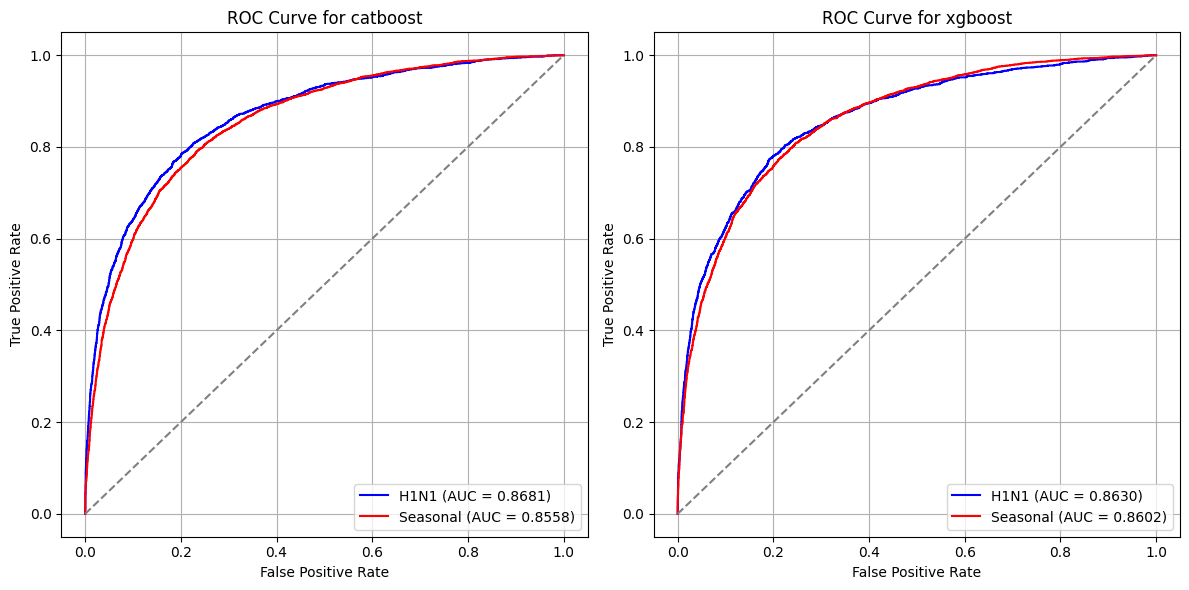

In [77]:
result_h1n1_catboost_optimal = train_model(
    target='h1n1_vaccine',
    model_type='catboost',
    # params=optimal_params_catboost_h1n1
)
result_seasonal_catboost_optimal = train_model(
    target='seasonal_vaccine',
    model_type='catboost',
    params=optimal_params_catboost_seasonal
)

result_h1n1_xgboost_optimal = train_model(
    target='h1n1_vaccine',
    model_type='xgboost',
    params=optimal_params_xgboost_h1n1
)
result_seasonal_xgboost_optimal = train_model(
    target='seasonal_vaccine',
    model_type='xgboost',
    # params=optimal_params_xgboost_seasonal
)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
roc_auc_catboost = process_result(result_h1n1_catboost_optimal, result_seasonal_catboost_optimal, 'catboost', axes[0])
roc_auc_xgboost = process_result(result_h1n1_xgboost_optimal, result_seasonal_xgboost_optimal, 'xgboost', axes[1])

print(f'Mean ROC AUC (catboost) = {roc_auc_catboost:.4f}')
print(f'Mean ROC AUC (xgboost) = {roc_auc_xgboost:.4f}')

plt.tight_layout()
plt.show()

In [ ]:
from datetime import datetime

def get_test_probabilities(model: Any) -> np.ndarray:
    return model.predict_proba(test_features_xgboost)[:, 1]

submission = pd.read_csv('data/submission_format.csv')

h1n1_model = train_model('h1n1_vaccine', 'xgboost', use_whole_dataset=True).model
seasonal_model = train_model('seasonal_vaccine', 'xgboost', use_whole_dataset=True).model

submission['h1n1_vaccine'] = get_test_probabilities(h1n1_model)
submission['seasonal_vaccine'] = get_test_probabilities(seasonal_model)

submission.to_csv(f'submission/submission_{datetime.now().isoformat(sep='_')}.csv', index=False)

submission

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.171270,0.349341
1,26708,0.021499,0.045364
2,26709,0.162811,0.352967
3,26710,0.515226,0.869933
4,26711,0.390040,0.538098
...,...,...,...
26703,53410,0.252479,0.597809
26704,53411,0.183881,0.282557
26705,53412,0.175007,0.274644
26706,53413,0.025884,0.225328
